# License

The code in this notebook is free to be used, edited and redistributed by anyone free of charge. Please cite Linssen et al. (2024) when making use of _sunbather_ and/or the code in this notebook.

# Scientific goal

In this notebook, we demonstrate how sunbather can be used to obtain mass-loss rate estimates from spectral observations. Fitting Parker wind models to helium data is a commonly applied method, but it can result in a degeneracy between the free parameters of the Parker wind model: the temperature and the mass-loss rate. Constraints on the mass-loss rate are not very stringent in that case. In this notebook, we follow the approach described in Linssen et al. (2022), to mitigate this. We fit the helium line and combine this with additional constraints on the Parker wind temperature parameter, in order to break the degeneracy and get better constraints on the mass-loss rate. We first do this for a simple case of a spectrum that we generate from random data, which will reproduce the results of Fig. 6 from Linssen et al. (2024). Then, we move on to fitting the observed He 10830 Å signal of TOI-2134 b from Zhang et al. (2023). We will perform fits with both an atmospheric composition that is a hydrogen/helium mixture in the solar ratio, and a 100x solar metallicity atmosphere. This reproduces the results of Fig. 7 from Linssen et al. (2024).

# Methodology

We need to run a grid of Parker wind models with different temperatures ($T_0$) and mass-loss rates ($\dot{M}$), which can be computationally expensive depending on the size of the grid. Here, we include the commands to run your own grid (as commented out Python lines), but by default this notebook uses the model runs that we have pre-run to save computation time.

One analysis typically consists of five main steps, which are the same as those of *sunbather*'s "fit_helium" example notebook:

- Step 1. Generate the $T_0$-$\dot{M}$ grid of isothermal (!) Parker wind models.
- Step 2. Run the Parker wind models through Cloudy to find a non-isothermal temperature profile and the metastable helium density.
- Step 3. Make synthetic helium transit spectra for each model and fit those to the observed value (to obtain the _likelihood_).
- Step 4. Constrain the temperature parameter-space by assessing the model self-consistency (to obtain the _prior_).
- Step 5. Combine the data fit with the model self-consistency (to obtain the _posterior_).

Steps 4 and 5 can optionally also be skipped in the case of spectrally resolved observations, since then the $T_0-\dot{M}$-degeneracy is usually less strong, and no prior is needed to obtain good constraints.

Some of the steps we need to take to go through this analysis have to be taken outside of *sunbather* (e.g. storing the planet parameters in the planets.txt file and making the stellar SEDs available to *Cloudy*). Some steps are part of the "core functionality" of the *sunbather* package, which means they can be executed with a single command-line call to a Python script (e.g. generating the Parker wind profiles, running them through the Cloudy algorithm). And some of the steps are performed inside a user-made Python file/Jupyter notebook (e.g. saving the helium spectrum of each Parker wind profile, doing the Bayesian analysis to extract the mass-loss rate). In this notebook, we will provide all neccessary code.

# Preparation

To reproduce these results, we assume you have all codes set-up. That is; you have downloaded *sunbather* and installed its dependencies (the Python packages, including *p-winds*). You have installed *Cloudy* and have the path to it stored as the *\$CLOUDY_PATH* environmental variable. You have created your "project" folder, and have the path to it stored as the *\$SUNBATHER_PROJECT_PATH* environmental variable. These steps are described in more detail in the "installation" section of the _sunbather_ wiki.

Before *sunbather* can create Parker wind profiles, we need to make sure the parameters of the system are available to the code. The parameters are stored in the *$SUNBATHER_PROJECT_PATH/planets.txt* file. To run the models for the generic hot Neptune mock retrieval, as well as the TOI-2134 b models, you will need to add their parameters.

> **Add the following two lines to _$SUNBATHER_PROJECT_PATH/planets.txt_:**<br><br>
> TOI2134b,TOI-2134 b,0.240,0.709,0.078,0.0287,0.744,0.20,TOI2134.spec #parameters from Zhang et al. (2023)
<br>
> hotNeptune,generic hot Neptune,0.5,1.0,0.05,0.1,1.0,0.,solar.spec

The last column of the _planets.txt_ file specifies the **name** of the stellar SED that we want to use. The SED with exactly this name must be available to *Cloudy*, so it must be placed in its source folder, specifically: _\$CLOUDY_PATH/data/SED/_. In the */sunbather/stellar_SEDs/* folder, the solar.spec file is provided, which is combined from Woods et al. (2005) and Rottman (2005). The TOI2134.spec file is also provided, which is downloaded from the online material of Zhang et al. (2023) ( https://iopscience.iop.org/article/10.3847/2041-8213/aced51 ) and put in the format accepted by *sunbather* (see wiki).
> **The only step you need to take here, is make sure these two spectra are in Cloudy's SED folder: \$CLOUDY_PATH/data/SED/ (so copy them there).**

# ------------

# Function definitions

Since this notebook contains quite a lot of functions for performing the various calculations, we have grouped them all together here, so that the rest of the notebook has improved readability. Once the functions are defined, most parts of the analysis are really only one line of code!

In [1]:
import sys
sys.path.append('/Users/dion/src/sunbather/src/') #add your path to /sunbather/src/ here

#import sunbather modules
import tools
import RT

#import other modules
import pandas as pd
from scipy.integrate import trapezoid
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as sps
import traceback
from scipy.optimize import curve_fit
import spectres #to resample synthetic spectra to the wavelength grid of observations (pip install spectres)

#for interactive matplotlib plots
%matplotlib notebook

In [2]:
### Useful functions ###

def get_xyz(df):
    '''
    Takes as input a Pandas DataFrame which has the x-values
    as the index, and the y-values as the column names,
    and the z-values as the dataframe contents.
    Returns three 1D arrays with the x, y, z values 
    that can e.g. be plotted with matplotlib tricontour.
    '''
    
    stacked_data = df.stack()
    stacked_data = stacked_data.dropna()
    x_values = stacked_data.index.get_level_values(0).tolist()  # x-values
    y_values = stacked_data.index.get_level_values(1).tolist()  # y-values
    z_values = stacked_data.tolist()  # z-values    
    
    return x_values, y_values, z_values


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=1000):
    '''
    Cuts a colormap to a smaller range.
    from https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    '''

    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def get_array_from_contour(cn, levelnum):
    '''
    Takes an ax.contour object and returns the 'levelnum'-th contour as an
    array of x and y values. You can then extract the min/max values from
    such a contour/array.
    '''
    
    lines = []
    for line in cn.collections[levelnum].get_paths():
        lines.append(line.vertices)

    if lines:
        x = np.concatenate(lines, axis=0)[:,0]
        y = np.concatenate(lines, axis=0)[:,1]
    else:
        print("No 1 sigma contour could be found")
        x, y = None, None

    return x, y


### Functions that calculate statistics ###

def calc_chisqs_He10830(Tstrucpath, observed_wavs, observed_ea, observed_sig_ea,
                        instrument_R=None,
                        T0low=2000, T0up=12000, T0step=100,
                        Mdotlow=8, Mdotup=12, Mdotstep=0.05,
                        **kwargs):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the metastable helium line, compares it to the observed
    profile and calculates the chi-squared value.
    Expects excess absorption and error in units of %.
    '''

    Mdots = ["%.3f" % Mdot for Mdot in np.arange(Mdotlow, Mdotup+1e-5, Mdotstep)] #set up a grid of Mdot
    T0s = ["%i" % T0 for T0 in np.arange(T0low, T0up+1e-5, T0step)] #set up a grid of T_0
    
    chisqs = pd.DataFrame(columns=Mdots, index=T0s, dtype=float)

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                #read in the converged simulation for this combination of T0 and Mdot by specifying the path
                sim = tools.Sim(Tstrucpath+'parker_'+T0+'_'+Mdot+'/converged')
                #we calculate the model spectrum on a high-resolution grid
                highres_wavs = np.linspace(10830, 10836, 100)
                FinFout, lines_found, lines_not_found = RT.FinFout(sim, highres_wavs, 'He', **kwargs)
                #convert to excess absorption in units of %
                model_excess_absorption = (np.max(FinFout) - FinFout) * 100
                #convolve with instrumental resolution, if any was passed
                if instrument_R is not None:
                    model_excess_absorption = RT.convolve_spectrum_R(highres_wavs, model_excess_absorption, instrument_R) #careful - it gets the same variable name
                #resample model to the observed wav points
                model_excess_absorption_ondata = spectres.spectres(observed_wavs, highres_wavs, model_excess_absorption, fill=0., verbose=False)
                #calculate chi squared
                chisq = np.sum(((model_excess_absorption_ondata - observed_ea) / observed_sig_ea)**2)
                #save chisq value in the pandas dataframe
                chisqs[Mdot][T0] = chisq

            except FileNotFoundError as e: #then this Parker wind model was not calculated
                pass
            
            except Exception as e: #if something else went wrong
                traceback.print_exc()

    return chisqs


def calc_EWs_He10830(Tstrucpath, 
                     T0low=2000, T0up=12000, T0step=100,
                     Mdotlow=8, Mdotup=12, Mdotstep=0.05,
                     **kwargs):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the metastable helium line and integrates it to get the EW.
    '''

    Mdots = ["%.3f" % Mdot for Mdot in np.arange(Mdotlow, Mdotup+1e-5, Mdotstep)] #set up a grid of Mdot
    T0s = ["%i" % T0 for T0 in np.arange(T0low, T0up+1e-5, T0step)] #set up a grid of T_0
    
    model_EWs = pd.DataFrame(columns=Mdots, index=T0s, dtype=float)

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                #read in the converged simulation for this combination of T0 and Mdot by specifying the path
                sim = tools.Sim(Tstrucpath+'parker_'+T0+'_'+Mdot+'/converged')
                #set up the wavelength array in vacuum angstrom units
                wavs = np.logspace(np.log10(10831), np.log10(10835), num=100)
                #run the radiative transfer (to check if all lines were calculated, print lines_found)
                FinFout, lines_found, lines_not_found = RT.FinFout(sim, wavs, 'He', **kwargs)
                #convert from Fin/Fout to excess absorption - this assumes we reach the continuum somewhere
                absorption = np.max(FinFout) - FinFout
                #integrate to get EW
                EW = trapezoid(absorption, x=wavs)
                #save EW value in the pandas dataframe
                model_EWs[Mdot][T0] = EW
                
            except FileNotFoundError as e: #then this Parker wind model was not calculated
                pass
            
            except Exception as e: #if something else went wrong
                traceback.print_exc()

    return model_EWs


def metaHe_weighted_T(sim):
    '''
    Calculates the mean temperature and its standard devation of the atmosphere weighted by
    the metastable helium number density (Eq. 4 & 5 in Linssen et al. 2022).
    '''
    
    #in Cloudy, not all bins have the same thickness, so we must compensate for that to do a fair weighting
    bin_thickness = np.diff(np.insert(sim.den.depth.values, 0, 0.))
    #the metastable helium state is the second lowest energy level and thus stored in the He[2] column of the density file
    T_He = np.sum(sim.ovr.Te.values * sim.den['He[2]'].values * bin_thickness) / np.sum(sim.den['He[2]'].values * bin_thickness)
    sigmaT = np.sqrt( np.sum(sim.den['He[2]'].values * bin_thickness * (sim.ovr.Te.values - T_He)**2) / np.sum(sim.den['He[2]'].values * bin_thickness) )
    
    return T_He, sigmaT


def calc_dT_helium(Tstrucpath,
            T0low=2000, T0up=12000, T0step=100,
            Mdotlow=8, Mdotup=12, Mdotstep=0.05):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the mean temperature weighted by the metastable helium density
    and its standard deviation. Calculates the temperature difference between
    the isothermal value and the He-weighted value, which can be used as 
    a measure of model self-consistency.
    '''
    
    Mdots = ["%.3f" % Mdot for Mdot in np.arange(Mdotlow, Mdotup+1e-5, Mdotstep)] #set up a grid of Mdot
    T0s = ["%i" % T0 for T0 in np.arange(T0low, T0up+1e-5, T0step)] #set up a grid of T_0

    T_He = pd.DataFrame(columns=Mdots, index=T0s, dtype=float) #stores the weighted T
    sigmaT = T_He.copy() #stores standard deviation of T(r) around T_He
    dT = T_He.copy() #stores T_He - isothermal T

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                sim = tools.Sim(Tstrucpath+'/parker_'+T0+'_'+Mdot+'/converged') #load the converged simulation
                ClT, ClsigmaT = metaHe_weighted_T(sim) #find the T_He and sigT_He for this simulation
                T_He[Mdot][T0] = ClT
                sigmaT[Mdot][T0] = ClsigmaT
                dT[Mdot][T0] = ClT - int(T0)

            except FileNotFoundError: #then this profile was not calculated
                pass
            
    return dT, sigmaT


### Functions that calculate the Bayesian terms ###

def calc_likelihood_resolved(chisq_fit):
    '''
    Calculates the likelihood of a spectrally resolved fit to data,
    based on the chi-squared value.

    See e.g. https://philuttley.github.io/statistical-inference/10-mle_model_fitting/index.html
    for how the chi-squared statistic relates to the likelihood.
    '''

    likelihood = np.exp(-chisq_fit.values / 2.)

    likelihood = pd.DataFrame(columns=chisq_fit.columns.values, index=chisq_fit.index.values, 
                             data=likelihood, dtype=float) #turn into pd.DataFrame
    
    return likelihood


def calc_likelihood_unresolved(nsig_fit):
    '''
    Calculates the likelihood of spectrally unresolved data,
    expects a pandas dataframe that stores the number of 
    errorbars difference between model and data.
    '''

    likelihood = sps.norm.pdf(nsig_fit.abs())

    likelihood = pd.DataFrame(columns=nsig_fit.columns.values, index=nsig_fit.index.values, 
                             data=likelihood, dtype=float) #turn into pd.DataFrame
    
    return likelihood


def calc_prior(dT, sigmaT):
    '''
    Calculates a prior based on the model temperature self-consistency.
    See Linssen et al. (2022) for details on the choice of prior evaluation.
    '''

    #check that dT and sigmaT are defined on the same T-Mdot grid
    assert np.array_equal(dT.index.values, sigmaT.index.values), "Different temperature grids."
    assert np.array_equal(dT.columns.values, sigmaT.columns.values), "Different mass-loss rate grids."

    T0grid = dT.index.values.astype(float)
    Mdotgrid = dT.columns.values.astype(float)

    #assume prior is a normal distribution around dT=0 with std dev sigmaT
    number_sigma = dT / sigmaT
    prior = sps.norm.pdf(number_sigma)
    #now normalize the prior
    prior[np.isnan(prior)] = 0.
    prior_sum = trapezoid(trapezoid(prior, axis=1, x=Mdotgrid), x=T0grid)
    prior = prior / prior_sum

    prior = pd.DataFrame(columns=dT.columns.values, index=dT.index.values, 
                             data=prior, dtype=float) #turn into pd.DataFrame
    
    return prior


def calc_posterior(prior, likelihood):
    '''
    Combines the prior from the T0-T_He analysis with the likelihoods
    from the data fit with Bayes' theorem to calculate the posterior.
    '''

    if isinstance(prior, pd.DataFrame):
        #check that the prior and likelihoods are defined on the same T-Mdot grid
        assert np.array_equal(prior.index.values, likelihood.index.values), "Different temperature grids."
        assert np.array_equal(prior.columns.values, likelihood.columns.values), "Different mass-loss rate grids."

    T0grid = likelihood.index.values.astype(float)
    Mdotgrid = likelihood.columns.values.astype(float)

    integrand = prior*likelihood
    integrand[np.isnan(integrand)] = 0.
    evidence = trapezoid(trapezoid(integrand, axis=1, x=Mdotgrid), x=T0grid)
    posterior = integrand / evidence

    posterior = pd.DataFrame(columns=likelihood.columns.values, index=likelihood.index.values, 
                             data=posterior, dtype=float) #turn into pd.DataFrame


    #calculate marginalized posteriors
    post_Mdot = trapezoid(posterior.values, axis=0, x=T0grid)
    post_T0 = trapezoid(posterior.values, axis=1, x=Mdotgrid)

    post_Mdot_cum = cumulative_trapezoid(post_Mdot, x=Mdotgrid)
    lowsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.16)]
    mid_Mdot = Mdotgrid[np.argmin(np.abs(post_Mdot_cum - 0.5)) + 1]
    upsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.84) + 1]
    print("Constraints from marginalized posteriors (not necessarily normally distributed!):")
    print(f"log10(Mdot) = {mid_Mdot} + {upsig_Mdot-mid_Mdot} - {mid_Mdot-lowsig_Mdot}")

    post_T0_cum = cumulative_trapezoid(post_T0, x=T0grid)
    lowsig_T0 = T0grid[np.argmax(post_T0_cum > 0.16)]
    mid_T0 = T0grid[np.argmin(np.abs(post_T0_cum - 0.5)) + 1]
    upsig_T0 = T0grid[np.argmax(post_T0_cum > 0.84) + 1]
    print(f"T0 = {mid_T0} + {upsig_T0-mid_T0} - {mid_T0-lowsig_T0}")


    return posterior


### Functions that plot stuff ###

def plot_chisq_fit(chisq_fit,
                   dof=None, bounds_T0=None, bounds_Mdot=None,
                   title=None, save=None, fig=None, ax=None):
    '''
    Makes a standard plot of the Parker wind models fitted to the data.
    In this case, we fit the resolved line shape, and
    the colormap shows the chi squared statistic.
    '''

    pixT = float(chisq_fit.index[1])-float(chisq_fit.index[0]) #T step size
    pixM = float(chisq_fit.columns[1]) - float(chisq_fit.columns[0]) #Mdot step size

    if dof != None: #then we assume you want to plot the reduced chi squared
        plotted_vals = chisq_fit / dof
        cbar_label = r'Reduced $\chi ^2$'
    else:
        plotted_vals = chisq_fit
        cbar_label = r'$\chi ^2$'

    
    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False

    im = ax.imshow(plotted_vals.T, cmap='Blues_r', norm=matplotlib.colors.LogNorm(), 
                    origin='lower', aspect='auto', interpolation='none',
                    extent=[float(chisq_fit.index[0])-0.5*pixT, float(chisq_fit.index[-1])+0.5*pixT, 
                              float(chisq_fit.columns[0])-0.5*pixM, float(chisq_fit.columns[-1])+0.5*pixM])
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    fig.colorbar(im, label=cbar_label)
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if _showplot:
        plt.show()


def plot_nsig_fit(nsig_fit, bounds_T0=None, bounds_Mdot=None,
             title=None, save=None, fig=None, ax=None):
    '''
    Makes a standard plot of the Parker wind models fitted to the data.
    In this case, we fit the EW of the model to the EW of the data, and
    the colormap simply indicates how many data errorbars difference there is.
    '''
    
    cmap = plt.get_cmap('Blues_r')
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=5)

    pixT = float(nsig_fit.index[1]) - float(nsig_fit.index[0]) #T step size
    pixM = float(nsig_fit.columns[1]) - float(nsig_fit.columns[0]) #Mdot step size

    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False

    im = ax.imshow(nsig_fit.T.abs(), cmap=cmap, norm=normalize, origin='lower', aspect='auto', interpolation='none',
                      extent=[float(nsig_fit.index[0])-0.5*pixT, float(nsig_fit.index[-1])+0.5*pixT, 
                              float(nsig_fit.columns[0])-0.5*pixM, float(nsig_fit.columns[-1])+0.5*pixM])
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    fig.colorbar(im, label=r'$\Delta\sigma$')
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if _showplot:
        plt.show()


def plot_selfcons(dT, sigmaT,
                  bounds_T0=None, bounds_Mdot=None,
                  title=None, fig=None, ax=None):
    '''
    Makes a standard plot of the self-consistency of the Parker wind parameter space.
    Self-consistent models are white, while blue/red models indicate models for which
    Cloudy indicates that the temperature in the helium line-forming region is
    cooler/hotter than that assumed in creating the isothermal profiles, respectively.
    The dotted lines indicate 1 standard deviation discrepancy. 
    '''
    
    cmap = truncate_colormap(plt.get_cmap('seismic'), 0.2, 0.8)
    normalize = matplotlib.colors.Normalize(vmin=-4000, vmax=4000)

    pixT = float(dT.index[1])-float(dT.index[0]) #T step size
    pixM = float(dT.columns[1]) - float(dT.columns[0]) #Mdot step size

    
    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False

    im = ax.imshow(dT.T, cmap=cmap, norm=normalize, origin='lower', aspect='auto', interpolation='none',
                      extent=[float(dT.index[0])-0.5*pixT, float(dT.index[-1])+0.5*pixT, 
                              float(dT.columns[0])-0.5*pixM, float(dT.columns[-1])+0.5*pixM])
    #plot the 1 sigma line (i.e. dT = sigmaT)
    sig1lines = ax.contour(dT.index.astype(float), dT.columns.astype(float), (dT / sigmaT).T, 
                           levels=[-1,1], zorder=1, colors='black', linestyles='dotted')
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    fig.colorbar(im, label=r'$T_{He} - T_0$ [K]')
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    if _showplot:
        plt.show()


def plot_posterior(posterior,
                   bounds_T0=None, bounds_Mdot=None,
                   title=None, save=None, log=False):
    '''
    Plots the posterior distribution and the marginalized distributions.
    Prints the 1 sigma confidence intervals, at the precision of the T0/Mdot-grid.
    '''

    T0grid = posterior.index.values.astype(float)
    Mdotgrid = posterior.columns.values.astype(float)
    post = posterior.values
    
    pixT = np.diff(T0grid)[0] #T step size
    pixM = np.diff(Mdotgrid)[0] #Mdot step size

    #calculate marginalized posteriors
    post_Mdot = trapezoid(post, axis=0, x=T0grid)
    post_T0 = trapezoid(post, axis=1, x=Mdotgrid)

    post_Mdot_cum = cumulative_trapezoid(post_Mdot, x=Mdotgrid)
    lowsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.16)]
    mid_Mdot = Mdotgrid[np.argmin(np.abs(post_Mdot_cum - 0.5)) + 1]
    upsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.84) + 1]

    post_T0_cum = cumulative_trapezoid(post_T0, x=T0grid)
    lowsig_T0 = T0grid[np.argmax(post_T0_cum > 0.16)]
    mid_T0 = T0grid[np.argmin(np.abs(post_T0_cum - 0.5)) + 1]
    upsig_T0 = T0grid[np.argmax(post_T0_cum > 0.84) + 1]


    fig = plt.figure(figsize=(5, 5))
    gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(1, 3),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_T0 = fig.add_subplot(gs[0, 0])
    ax_Mdot = fig.add_subplot(gs[1, 1])

    im = ax.imshow(post.T, cmap=plt.get_cmap('Greys'), origin='lower', aspect='auto', interpolation='none',
                extent=[T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT, 
                        Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM])
    if log:
        im.set_norm(matplotlib.colors.LogNorm())
    ax_T0.plot(T0grid, post_T0, color='k')
    ax_Mdot.plot(post_Mdot, Mdotgrid, color='k')


    ax_T0.axvline(mid_T0, color='blue', linewidth=0.7)
    ax_T0.axvline(lowsig_T0, color='blue', linewidth=0.7, linestyle='dotted')
    ax_T0.axvline(upsig_T0, color='blue', linewidth=0.7, linestyle='dotted')
    ax_Mdot.axhline(mid_Mdot, color='blue', linewidth=0.7)
    ax_Mdot.axhline(lowsig_Mdot, color='blue', linewidth=0.7, linestyle='dotted')
    ax_Mdot.axhline(upsig_Mdot, color='blue', linewidth=0.7, linestyle='dotted')

    ax_T0.set_xticks([])
    ax_T0.set_yticks([])
    ax_Mdot.set_xticks([])
    ax_Mdot.set_yticks([])

    ax.set_xlim(T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT)
    ax_T0.set_xlim(T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT)
    ax.set_ylim(Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM)
    ax_Mdot.set_ylim(Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM)
    if bounds_T0 != None:
        ax_T0.set_xlim(*bounds_T0)
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax_Mdot.set_ylim(*bounds_Mdot)
        ax.set_ylim(*bounds_Mdot)

    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    if title != None:
        ax_T0.set_title(title)

    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    plt.show()


def plot_joint_constraint_resolved(dT, sigmaT, chisq_fit, posterior, 
                                   bounds_T0=None, bounds_Mdot=None, 
                                   title=None, save=None, fig=None, ax=None, 
                                   post_uptosigma=1, cmap_T=None,
                                  cmap_fit=None):
    '''
    Makes a standard plot of the posterior distribution, 
    on top of the prior (self-consistency) and likelihood (data fit) constraints.
    Also prints out the 1sigma bounds on T and Mdot.

    chisq_fit must be given, but dT, sigmaT and posterior can be passed as None
    if they should not be plotted.
    '''

    assert post_uptosigma <=3, "Maximum value of post_uptosigma is 3"

    if cmap_T is None:
        cmap_T = truncate_colormap(plt.get_cmap('autumn'), 0.35, 0.65)
    if cmap_fit is None:
        cmap_fit = truncate_colormap(plt.get_cmap('winter_r'), 0.35, 0.65)
    

    if fig == None and ax == None:
        showplot = True
        fig, ax = plt.subplots(1)
    else:
        showplot = False
    
    #### Plot the model temperature discrepancy (i.e. prior)
    if dT is not None and sigmaT is not None:
        nsig_T = dT / sigmaT

        x, y, z = get_xyz(nsig_T)

        ax.tricontour(x, y, z, cmap=cmap_T, levels=[0], zorder=0) #plots the orange line
        ax.tricontourf(x, y, np.abs(z), cmap=cmap_T, levels=[0,1,2], alpha=0.5, zorder=0) #plots the orange contours
    
    
    #### Plot the fit constraints (i.e. likelihood):
    likelihood = calc_likelihood_resolved(chisq_fit)
    likelihood = likelihood.fillna(0.)
    highest_likelihood = likelihood.max().max()
    sigma1_likelihood = highest_likelihood * np.exp(-1/2)
    sigma2_likelihood = highest_likelihood * np.exp(-4/2)
    sigma3_likelihood = highest_likelihood * np.exp(-9/2)
    
    x, y, z = get_xyz(likelihood)
    
    ax.tricontourf(x, y, z, cmap=cmap_fit, levels=[sigma2_likelihood, sigma1_likelihood, highest_likelihood], alpha=0.5, zorder=1) #plots the blue contours
    
    #### Plot the posterior
    if posterior is not None and post_uptosigma > 0:
        #calculate the posterior values that corresponds to the 1,2,3 sigma contours
        posterior_sorted = np.sort(posterior.values.flatten())[::-1]
        posterior_sum = np.sum(posterior_sorted)
        posterior_cumsum = np.cumsum(posterior_sorted)
        p1sigma = posterior_sorted[posterior_cumsum > 0.3935 * posterior_sum][0]
        p2sigma = posterior_sorted[posterior_cumsum > 0.8647 * posterior_sum][0]
        p3sigma = posterior_sorted[posterior_cumsum > 0.9889 * posterior_sum][0]
        post_levels = [p3sigma, p2sigma, p1sigma][3-post_uptosigma:]
        post_linestyles = ['dotted', 'dashed', 'solid'][3-post_uptosigma:]

        x, y, z = get_xyz(posterior)
        
        #plot the joint posterior 1/2/3 sigma lines:
        cn_post = ax.tricontour(x, y, z, levels=post_levels, linestyles=post_linestyles, colors='black', zorder=2)
        
        #print the posterior 1sigma credible intervals:
        pT0, pMdot = get_array_from_contour(cn_post, -1) #get last level (=1 sigma) from posterior
        if pT0 is not None and pMdot is not None:
            bestT0_index, bestMdot_index = np.unravel_index(np.nanargmax(posterior), posterior.shape)
            bestT0, bestMdot = float(posterior.index[bestT0_index]), float(posterior.columns[bestMdot_index]) #T, Mdot of the maximum of the posterior
            max_pMdot, min_pMdot, max_pT0, min_pT0 = np.max(pMdot), np.min(pMdot), np.max(pT0), np.min(pT0) #
            print(f"1 sigma constraints:\nlog10(Mdot) = {bestMdot} + {max_pMdot-bestMdot} - {bestMdot-min_pMdot}")
            print(f"T0 = {bestT0} + {max_pT0-bestT0} - {bestT0-min_pT0}")
    
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    if bounds_T0:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot:
        ax.set_ylim(*bounds_Mdot)
        ax.set_yticks(np.arange(bounds_Mdot[0], bounds_Mdot[1] + 0.5, 0.5))
    if title != None:
        ax.set_title(title)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if showplot:
        plt.show()


def plot_joint_constraint_unresolved(dT, sigmaT, nsig_fit, posterior, 
                                     bounds_T0=None, bounds_Mdot=None, 
                                     title=None, save=None, 
                                     fig=None, ax=None, cmap_T=None,
                                    cmap_fit=None, post_uptosigma=1):
    '''
    Makes a plot of the 1sigma posterior contour 
    on top of the prior (self-consistency) and likelihood (data fit) constraints.
    Also prints out the 1sigma bounds on T and Mdot, which are calculated
    based on the matplotlib contour, and thus involve interpolation to
    higher precision than the data itself.
    '''

    assert post_uptosigma <=3, "Maximum value of post_uptosigma is 3"

    if cmap_T is None:
        cmap_T = truncate_colormap(plt.get_cmap('autumn'), 0.35, 0.65)
    if cmap_fit is None:
        cmap_fit = truncate_colormap(plt.get_cmap('winter'), 0.35, 0.65)

     
    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False
    
    #### Plot the model temperature discrepancy (i.e. prior)
    if dT is not None and sigmaT is not None:
        nsig_T = dT / sigmaT

        x, y, z = get_xyz(nsig_T)

        ax.tricontour(x, y, z, cmap=cmap_T, levels=[0], zorder=0) #plots the orange line
        ax.tricontourf(x, y, np.abs(z), cmap=cmap_T, levels=[0,1,2], alpha=0.5, zorder=0) #plots the orange contours
    
    #### Plot the fit constraints (i.e. likelihood):
    x, y, z = get_xyz(nsig_fit)
    ax.tricontour(x, y, z, cmap=cmap_fit, levels=[0], zorder=1) #plots the blue line
    ax.tricontourf(x, y, np.abs(z), cmap=cmap_fit, levels=[0,1,2], alpha=0.5, zorder=1) #plots the blue contours
    
    #### Plot the posterior
    if posterior is not None and post_uptosigma > 0:
        #calculate the posterior values that corresponds to the 1,2,3 sigma contours
        posterior_sorted = np.sort(posterior.values.flatten())[::-1]
        posterior_sum = np.sum(posterior_sorted)
        posterior_cumsum = np.cumsum(posterior_sorted)
        p1sigma = posterior_sorted[posterior_cumsum > 0.3935 * posterior_sum][0]
        p2sigma = posterior_sorted[posterior_cumsum > 0.8647 * posterior_sum][0]
        p3sigma = posterior_sorted[posterior_cumsum > 0.9889 * posterior_sum][0]
        post_levels = [p3sigma, p2sigma, p1sigma][3-post_uptosigma:]
        post_linestyles = ['dotted', 'dashed', 'solid'][3-post_uptosigma:]

        x, y, z = get_xyz(posterior)

        #plot the joint posterior 1/2/3 sigma lines:
        cn_post = ax.tricontour(x, y, z, levels=post_levels, linestyles=post_linestyles, colors='black', zorder=2)
        
        #print the posterior 1sigma credible intervals:
        pT0, pMdot = get_array_from_contour(cn_post, -1) #get last level (=1 sigma) from posterior
        if pT0 is not None and pMdot is not None:
            bestT0_index, bestMdot_index = np.unravel_index(np.nanargmax(posterior), posterior.shape)
            bestT0, bestMdot = float(posterior.index[bestT0_index]), float(posterior.columns[bestMdot_index]) #T, Mdot of the maximum of the posterior
            max_pMdot, min_pMdot, max_pT0, min_pT0 = np.max(pMdot), np.min(pMdot), np.max(pT0), np.min(pT0) #
            print(f"1 sigma constraints:\nlog10(Mdot) = {bestMdot} + {max_pMdot-bestMdot} - {bestMdot-min_pMdot}")
            print(f"T0 = {bestT0} + {max_pT0-bestT0} - {bestT0-min_pT0}")
    
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    if bounds_T0:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot:
        ax.set_ylim(*bounds_Mdot)
        ax.set_yticks(np.arange(bounds_Mdot[0], bounds_Mdot[1] + 0.5, 0.5))
    if title != None:
        ax.set_title(title)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if _showplot:
        plt.show()

# --------------

# Retrieval of a mock spectrum of a hot Neptune

### Step 1: Create a grid of Parker wind profiles with p-winds (skip or run a rougher grid if you use our pre-run models)

This step can be done by calling `construct_parker.py` from the command-line with the proper arguments. Running `python construct_parker.py --help` will give an overview of the available arguments.  In our case, we will run *p-winds* with a 90% hydrogen, 10% helium composition, which is done by passing `-fH 0.9`. We will run a grid of models that span temperatures $T_0$ from 4000 to 7000 K in steps of 100 K, and log10-mass-loss rates $\dot{M}$ from 10.5 to 11.5 in steps of 0.05 dex. To run a grid of temperatures, we need to pass the lowest temperature, the highest temperature, and the step size to the `-T` argument, and similarly for the log-10 mass-loss rate `-Mdot`. Since in the future, we might want to explore different compositions, `construct_parker.py` always expects you to give a folder name `-pdir` where we want to store our Parker profiles. We reccommend using a descriptive name, so in this case we will go with *fH_0.9* and the path where our profiles will be saved is then _$SUNBATHER_PROJECT_PATH/parker_profiles/hotNeptune/fH_0.9/_.

> **The full command to create a grid of 90%hydrogen/10%helium Parker wind models is**: <br><br>
> `python construct_parker.py -plname hotNeptune -pdir fH_0.9 -T 4000 7000 100 -Mdot 10.5 11.5 0.05 -fH 0.9`

Additionally, with the `-cores` flag you can specify the number of parallel CPUs used. For this set of parameters, this command should take on the order of a few minutes. In the _$SUNBATHER_PROJECT_PATH/parker_profiles/hotNeptune/fH_0.9/_ folder, there should now be many different .txt files with the isothermal Parker wind structures, feel free to inspect them!

### Step 2: Run the Parker wind profiles through Cloudy (skip or run a rougher grid if you use our pre-run models)

This step can be done by calling `convergeT_parker.py` from the command-line with the proper arguments (`--help` will explain these). The $T_0$ and $\dot{M}$ grid-commands are the same as in Step 1. We also again need to specify a folder name where we want to save our *Cloudy* simulations (which is a different directory from where the isothermal Parker wind profiles were stored). In this case we will indicate that we used _Cloudy_ with metals turned off, i.e. a metallicity of z=0: `-dir z_0` and so our simulations will be saved in _$SUNBATHER_PROJECT_PATH/sims/1D/hotNeptune/z_0/_. We now again need to specify the folder where we want to read the Parker wind profiles from: `-pdir fH_0.9`. Since the *Cloudy* simulations are more time-consuming, you can easily run the different simulations in parallel by using the `-cores` flag. We then need to choose the atmospheric composition in _Cloudy_ (the default is solar composition). We will turn metals off, resulting in a pure H/He atmosphere in the solar ratio of 10:1. The argument for this is `-z 0`. The last thing we need to think about, is for which atomic/ionic species we want to save *Cloudy's* output. You can in principle save everything that's available, but this generally results in large file sizes (if metals are included). In our particular case, we want to fit helium observations, so we are fine with just saving the densities of the different atomic helium energy levels: `-save_sp He`.

> **The full command to run our grid of hydrogen/helium Parker wind models through *Cloudy* is:**: <br><br>
> `python convergeT_parker.py -plname hotNeptune -dir z_0 -pdir fH_0.9 -T 4000 7000 100 -Mdot 10.5 11.5 0.05 -z 0 -save_sp He`

Additionally, with the `-cores` flag you can specify the number of parallel CPUs used. For this set of parameters, this command should take many hours (roughly 10 minutes per model, and we are running roughy 30x20 models), and it is adviced to run it on a compute cluster. In the _$SUNBATHER_PROJECT_PATH/sims/1D/hotNeptune/fH_0.9/_ folder, there should now be many different sub-folders, with the output of the _Cloudy_ simulations, feel free to inspect the files! The _converged.png_ file shows the converged temperature structure, and the other _converged.*_ files are the _Cloudy_ output files.

### Step 3: Make transit spectra of the metastable helium triplet and fit the data (to obtain _likelihood_)

Since we first have to make our mock spectrum, and also because we perform two analyses (one fitting the spectrally resolved line shape, and one fitting the equivalent width), step 3 is broken up into three substeps here.

To make transit spectra, we can make use of the `FinFout()` module in `RT.py`. This code does not run from the command line, as you may want to process/plot/save the resulting transit spectrum in different ways. In our case, we will first calculate and plot the helium spectrum of the chosen model, which will end up being our mock spectrum. Then, we run all models and calculate their spectra, which we can compare/fit to the mock spectrum and calculate the likelihood of each model.

The `FinFout()` function takes a `Sim` object, which is a class defined in `tools.py`. For more information on how to use this class, we refer to the wiki. The `FinFout()` function takes three required arguments: the `Sim` object, a wavelength array in angstrom and vacuum, and the atomic/ionic species (or a list thereof) which to include in the calculations. In our case, we only need atomic helium, i.e. "He". There are a few optional arguments (see wiki), for example to specify a limb-darkening law or transit phase, but we will not use those here.

### Step 3a: Creating a mock spectrum

First, we create our mock spectrum by selecting one of the models that we ran, calculating its spectrum, and adding noise to it. If you ran your own grid of models in steps 1 and 2, you will already have the model and can readily calculate its spectrum. If instead, you made use of our pre-calculated grids, the model that we use here must be copied to the right folders in *\$SUNBATHER_PROJECT_PATH*. We have supplied all necessary files in the */sunbather/examples/materials/* folder, you just need to copy it to the correct folder structure within your project path. That is; the */sunbather/examples/materials/parker_profiles* folder must be copied/merged with your *\$SUNBATHER_PROJECT_PATH/parker_profiles* folder, and the */sunbather/examples/materials/sims* folder must be copied/merged with your *\$SUNBATHER_PROJECT_PATH/sims* folder (if you run your own models, sunbather automatically creates these folder structures).

<IPython.core.display.Javascript object>


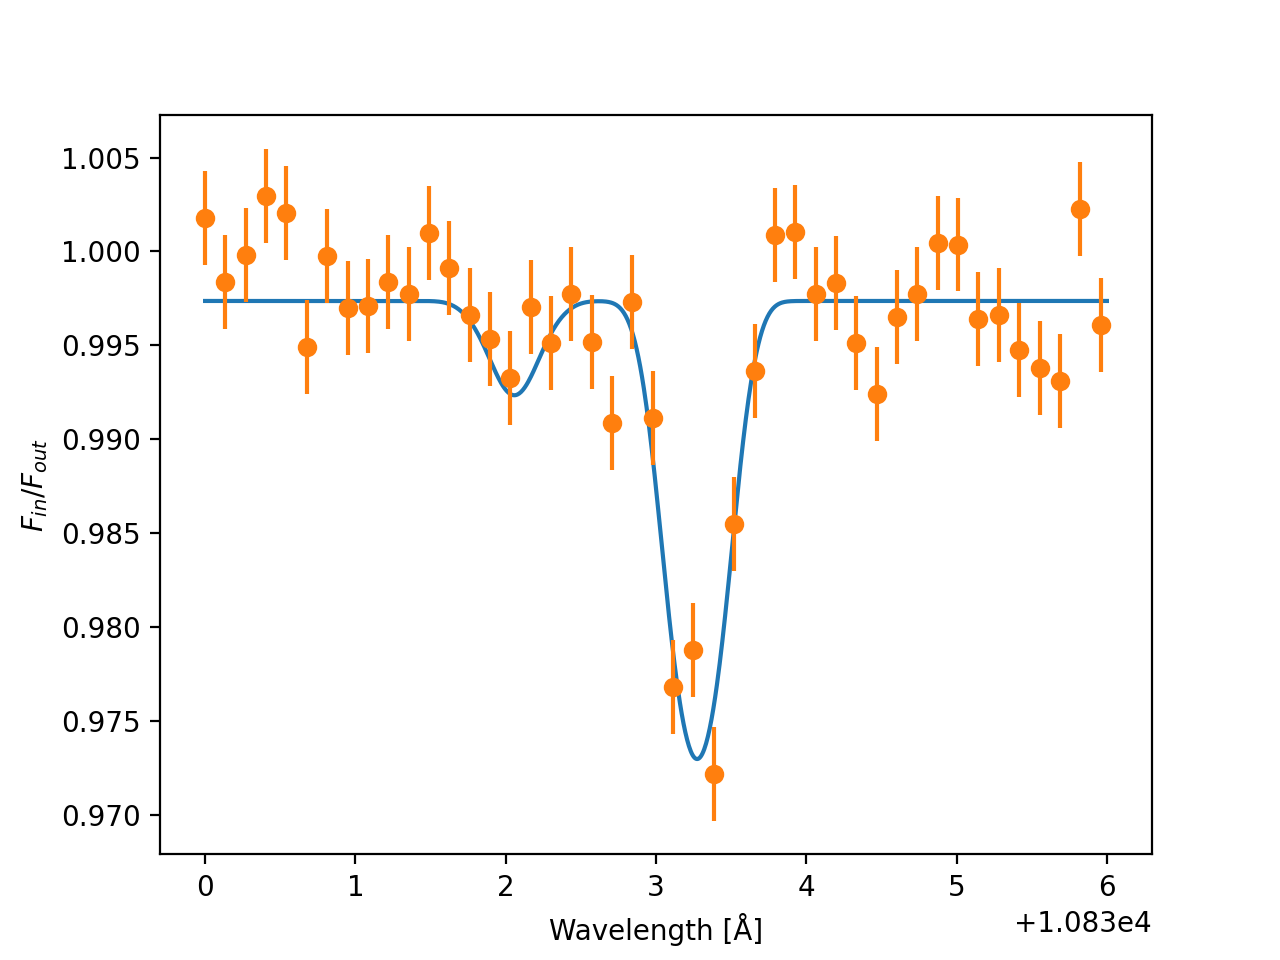

The true EW is 0.014318327135537906. We have drawn an observed EW = 0.013534265740520248 +- 0.0017897908919422383 (which is a 7.561925698388814 sigma detection)


In [3]:
#set random seed for consistent results
np.random.seed(0)
"""
#if due to a different numpy version, your generated mock spectrum is different,
#our generated mock spectrum can be found in 'materials/hotNeptune_helium_mock_spectrum.txt',
#which has stored np.column_stack((wavs, observed_excess_absorption, observed_excess_absorption_errorbar))
"""

#Let's make the spectrum of the generic hot Neptune
hotNep = tools.Sim(tools.projectpath+"/sims/1D/hotNeptune/z_1/parker_5100_10.950/converged")

wavs = RT.constantR_wavs(10830, 10836, 80000)
true_spec, _, _ = RT.FinFout(hotNep, wavs, 'He')

#draw errors from normal distribution
observed_errorbar = np.ones_like(wavs) * 0.0025 #just pick a number
observed_spec = np.random.normal(loc=true_spec, scale=observed_errorbar)

#convert into excess absorption in % which is what the calc_chisqs_He10830() function expects
#we pretend we don't know the continuum level and take it as the average away from the line (last 15 points)
observed_excess_absorption = 100 * (np.mean(observed_spec[-15:]) - observed_spec)
observed_excess_absorption_errorbar = 100 * observed_errorbar

highres_wavs = np.linspace(10830, 10836, 1000) #for smooth plotting
highres_true_spec, _, _ = RT.FinFout(hotNep, highres_wavs, 'He')


fig, ax = plt.subplots(1)
ax.plot(highres_wavs, highres_true_spec)
ax.errorbar(wavs, observed_spec, yerr=observed_errorbar, fmt='o')
ax.set_xlabel("Wavelength [Å]")
ax.set_ylabel(r"$F_{in}$/$F_{out}$")
plt.show()


#integrate the difference with the continuum to obtain the equivalent width
true_EW = trapezoid(np.max(true_spec) - true_spec, x=wavs) #units: Å
#let's choose the errorbar as 1/8 of the EW so that we will get around a 8 sigma detection
observed_EW_errorbar = true_EW / 8.
observed_EW = np.random.normal(loc=true_EW, scale=observed_EW_errorbar)
print(f"The true EW is {true_EW}. We have drawn an observed EW = {observed_EW} +- {observed_EW_errorbar} " \
      f"(which is a {observed_EW/observed_EW_errorbar} sigma detection)")


### Step 3b: Fitting the spectrally resolved line

With our mock spectrum and its EW calculated, we can now proceed to fitting it with a grid of Parker wind models.

Uncomment the next cell if you have run your own sunbather simulations and want to calculate the chi-squared values here.

In [4]:
#chisqs = calc_chisqs_He10830(tools.projectpath+'/sims/1D/hotNeptune/z_1/', 
#                                wavs, observed_excess_absorption, observed_excess_absorption_errorbar)
#chisqs.to_csv('materials/hotNeptune_chisqs.csv') #this overwrites the supplied file

In [5]:
#read in the chi-squared values from file
chisqs = pd.read_csv('materials/hotNeptune_chisqs.csv', index_col=0, dtype=float)

#calculate the likelihood (an actual p-value, contrary to the chi-squared statistic)
likelihood_resolved = calc_likelihood_resolved(chisqs)

We can already plot the chi-squared values of the resolved line fit to see what they look like:

<IPython.core.display.Javascript object>


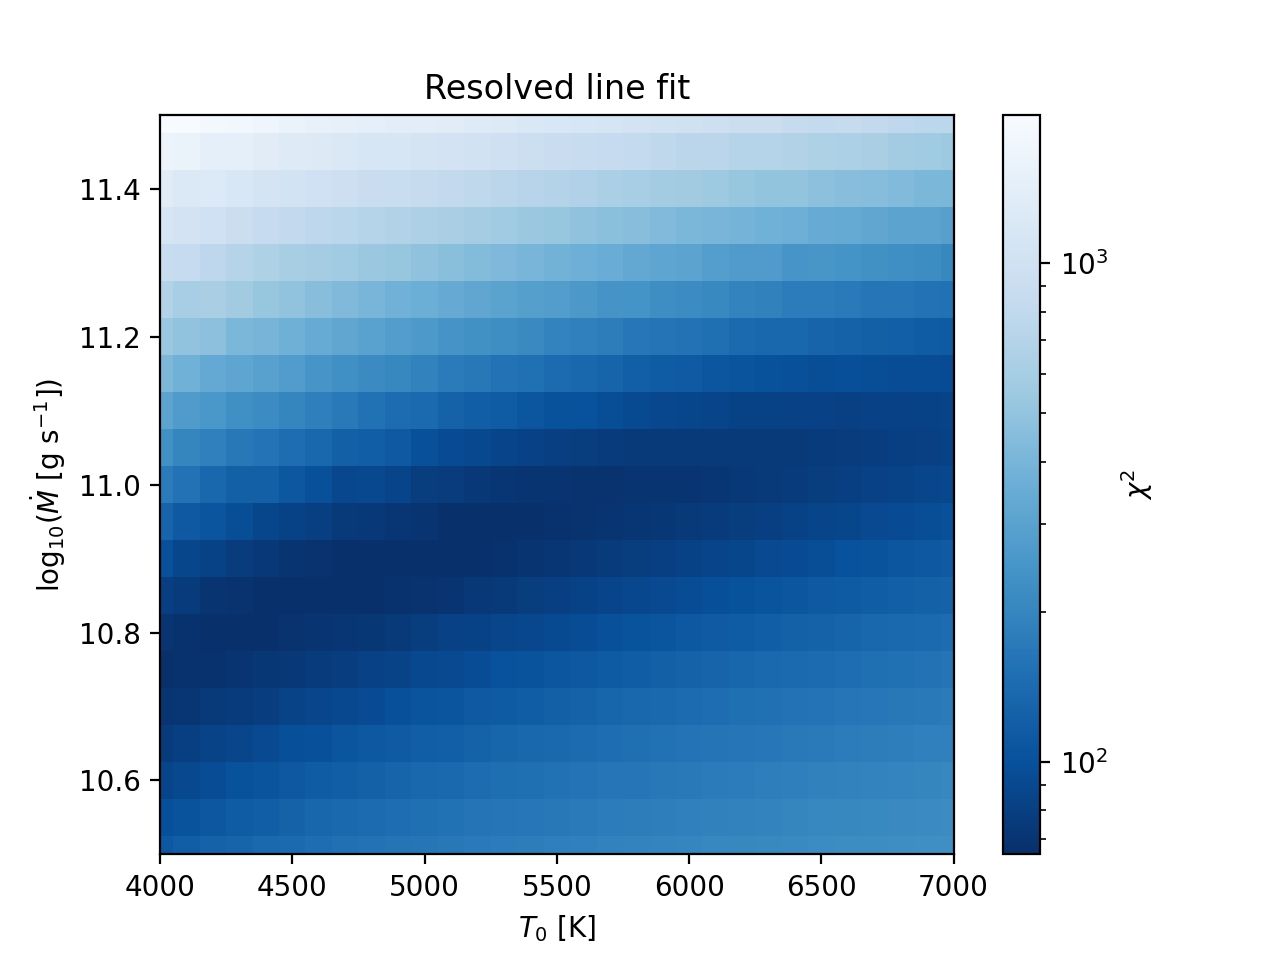

In [6]:
plot_chisq_fit(chisqs, bounds_T0=(4000,7000), bounds_Mdot=(10.5, 11.5), title='Resolved line fit')

### Step 3c: Fitting the line equivalent width (EW)

Uncomment the next cell if you have run your own sunbather simulations and want to calculate the model temperature self-consistency here.

In [7]:
#EWs = calc_EWs_He10830(tools.projectpath+'/sims/1D/hotNeptune/z_1/')
#EWs.to_csv('materials/hotNeptune_EWs.csv') #this overwrites the supplied file

In [8]:
#read in the EW values from file
EWs = pd.read_csv('materials/hotNeptune_EWs.csv', index_col=0, dtype=float)

#calculate the number of errorbars discrepancy between model and data
#this is what the calc_likelihood_unresolved() function expects
nsig_fit = (EWs - observed_EW)/observed_EW_errorbar

likelihood_unresolved = calc_likelihood_unresolved(nsig_fit)

We can already plot the number of errorbars discrepancy of the EW fit to see what they look like:

<IPython.core.display.Javascript object>


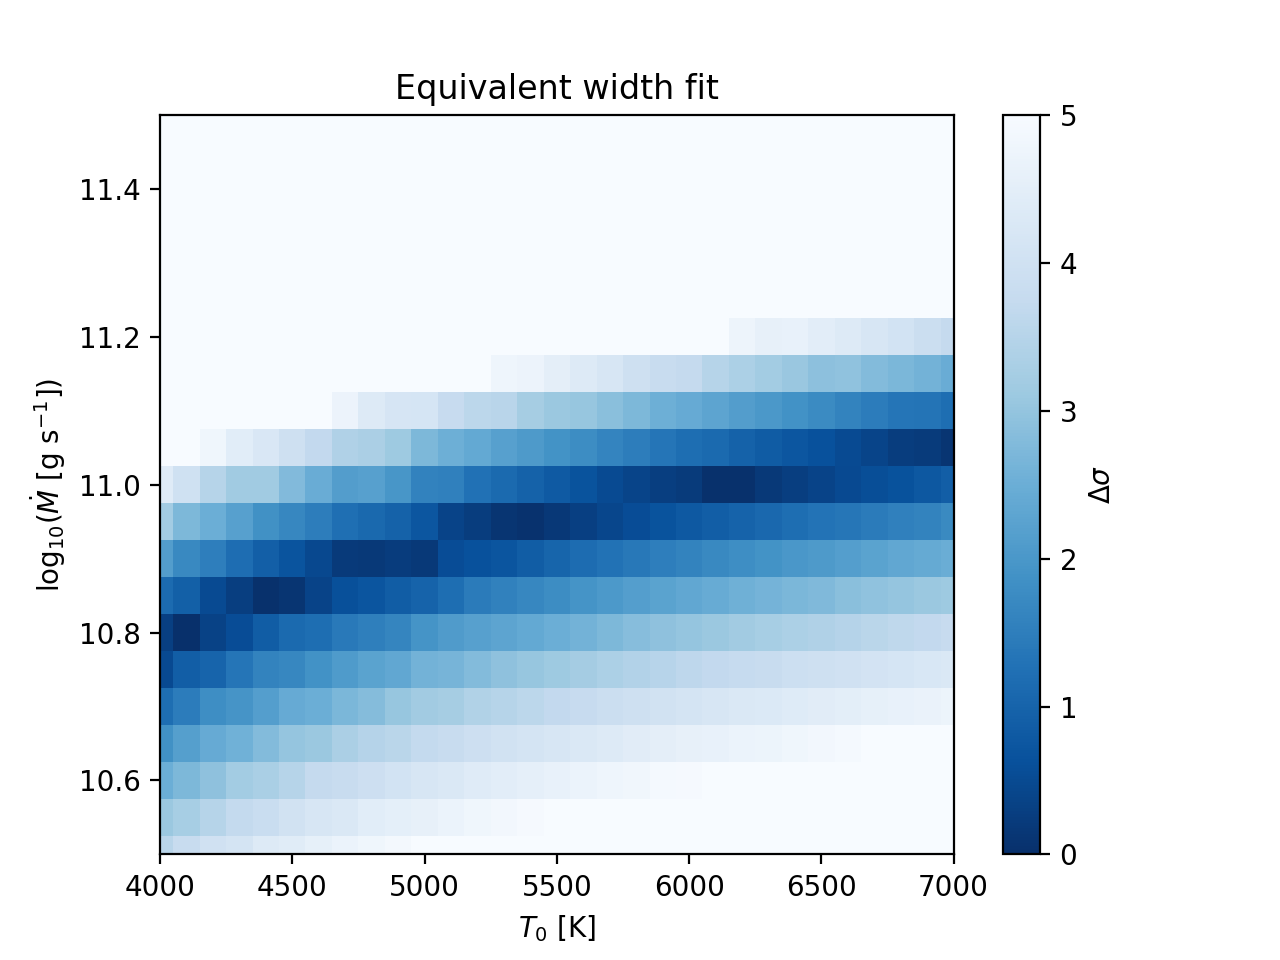

In [9]:
plot_nsig_fit(nsig_fit, bounds_T0=(4000,7000), bounds_Mdot=(10.5,11.5), title='Equivalent width fit')

### Step 4: Constraining the parameter space by assessing temperature self-consistency (to obtain _prior_)

We now assess the self-consistency of the Parker wind profiles in the helium line-forming region. To do that, we compare Cloudy's converged nonisothermal temperature profile to the initial isothermal value to identify models that are not self-consistent. As discussed in Linssen et al. (2022) and Linssen&Oklopcic (2023), there is not one single best way to do this comparison and it depends on the aim of the modeling effort. Since we are fitting helium observations here, we care most about the self-consistency of the Parker wind models in the region where the helium line forms. Thus, we calculate the mean of the nonisothermal temperature profiles weighted by the number density of metastable helium (this will be done by the `metaHe_weighted_T()` function and stored in the `T_He` variable and its standard deviation in the `sigmaT` variable). We then calculate the difference between this weighted temperature and the isothermal value $T_0$, which is the `dT` variable. This `dT` will be used for our prior on our Bayesian analysis. We are not confident in regions of the parameter space where |dT| >> 0 so we use a low prior there, while we are more confident in Parker wind models for which dT ~ 0 so we use a high prior there. This prior will only be used for the EW analysis. For the resolved fit analysis we use a flat prior.

Uncomment the next cell if you have run your own sunbather simulations and want to calculate the model equivalent width values here.

In [10]:
#dT, sigmaT = calc_dT(tools.projectpath+'/sims/1D/hotNeptune/z_1/')
#dT.to_csv('materials/hotNeptune_dT.csv', float_format='%.3e') #these overwrite the supplied files
#sigmaT.to_csv('materials/hotNeptune_sigmaT.csv', float_format='%.3e')

In [11]:
#read in the dT and sigmaT values from file
dT = pd.read_csv('materials/hotNeptune_dT.csv', index_col=0, dtype=float)
sigmaT = pd.read_csv('materials/hotNeptune_sigmaT.csv', index_col=0, dtype=float)    

#now we can calculate the prior based on the model self-consistency
prior = calc_prior(dT,  sigmaT)

We can plot the model self-consistencies to see what they look like (the dotted line in the figure indicates where dT = sigmaT, i.e. the 1 $\sigma$ region):

<IPython.core.display.Javascript object>


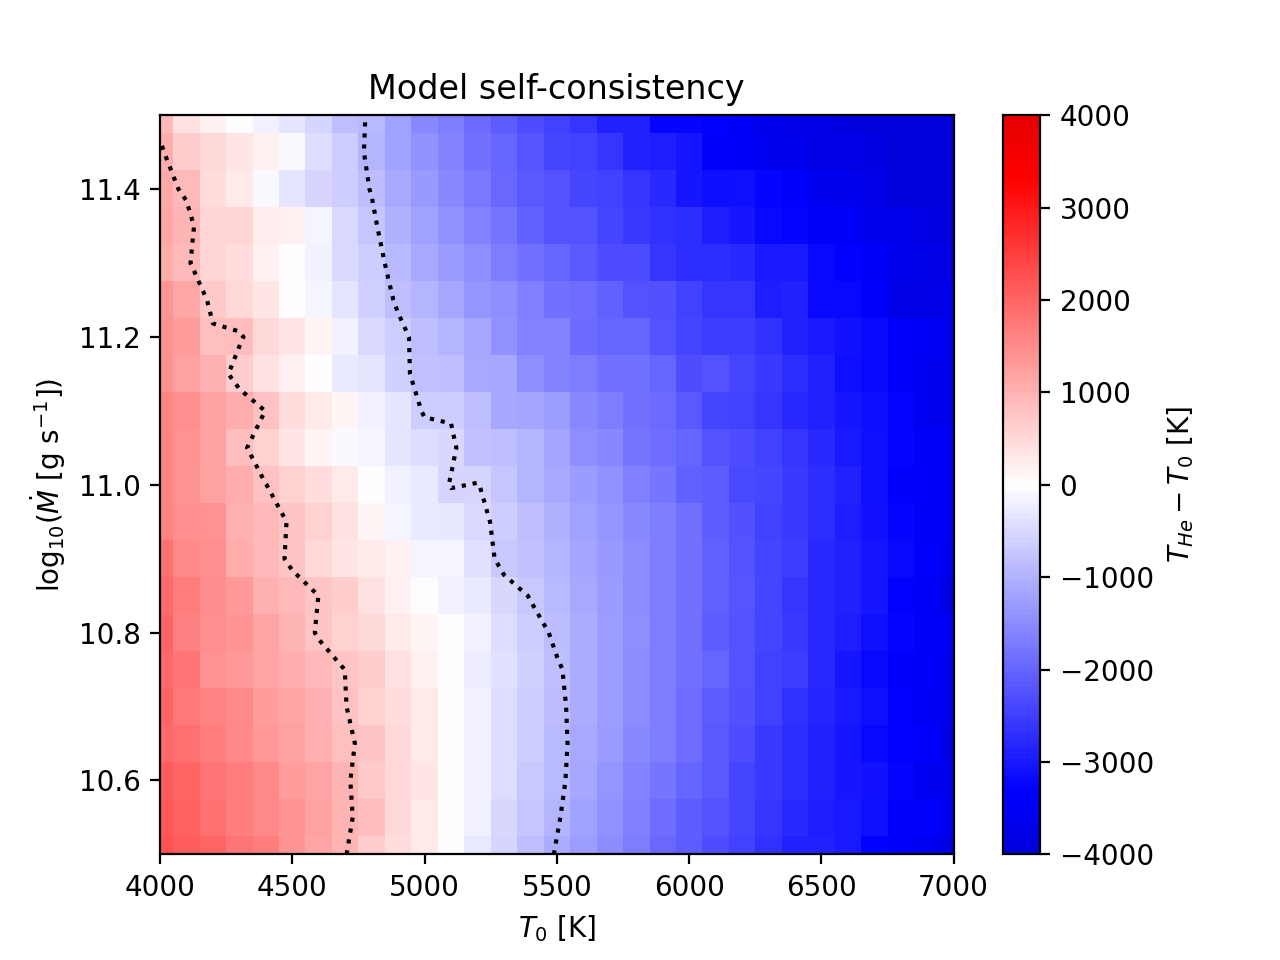

In [12]:
plot_selfcons(dT, sigmaT, bounds_T0=(4000,7000), bounds_Mdot=(10.5,11.5), title='Model self-consistency')

### Step 5: Combine likelihood and prior (to obtain _posterior_)

Now that we have both the fit of the models to the equivalent width, and the constraints on the self-consistency of the parameter space, we can combine the two in a Bayesian framework to get a posterior distribution of the temperature and atmospheric mass-loss rate of the planet. As a reminder, Bayes' theorem reads as follows:

$P(T_0,\dot{M} | data) = \dfrac{P(data | T_0, \dot{M}) \times P(T_0, \dot{M})}{P(data)} = \dfrac{P(data | T_0, \dot{M}) \times P(T_0, \dot{M})}{\int P(data | T_0, \dot{M}) \times P(T_0, \dot{M}) \; dT_0 \; d\dot{M}}$

Here, $P$ denotes any probability quantity. $P(T_0,\dot{M} | data)$ is the *posterior* distribution of $T_0$ and $\dot{M}$ (given the data, i.e. our observed helium line). This is what we want to know. $P(data | T_0, \dot{M})$ is the *likelihood* of the data, so this is what we get from fitting our data with a model as done in Step 3. $P(T_0, \dot{M})$ is the *prior* expectation of how likely each model is (i.e. the self-consistency of the Parker wind models based on the temperature and not the data, which we calculated in Step 4). $P(data)$ is what is called the *(model) evidence* and is basically a normalization factor. Here we write it as the integral over all considered models, which assumes that the true values of $T_0$ and $\dot{M}$ are within our considered parameter space. In our example, this assumption is probably fine, but if you run a scenario with a very limited extent of the $T_0-\dot{M}$ parameter space, the assumption might break and the posterior that you get from this code will not be robust.

The `calc_posterior()` function below evaluates Bayes' theorem and gives us the posterior distribution. It also calculates the marginalized posteriors, and prints the 1 $\sigma$ constraints on $T_0$ and $\dot{M}$. The `plot_posterior()` function plots the 2D posterior. Remember that for a 1D Gaussian, the 1, 2 and 3 $\sigma$ contours are defined by the area that comprises 68%, 95% and 99.7% of the probability density function. However, for a 2D Gaussian, these values are 39%, 86% and 89.9% (see e.g. https://corner.readthedocs.io/en/latest/pages/sigmas/), and that is what the plotting function uses to draw the contours.

In [13]:
#for the resolved line fit, we calculate the posterior with a flat prior
#we do this only so that calc_posterior() prints the constrained T0 and Mdot based on
#the likelihood alone, which we can then quote
posterior_resolved = calc_posterior(1., likelihood_resolved)

#for the EW fit, we calculate the posterior with the prior based on model self-consistency
posterior_unresolved = calc_posterior(prior, likelihood_unresolved)

Constraints from marginalized posteriors (not necessarily normally distributed!):
log10(Mdot) = 10.9 + 0.09999999999999964 - 0.09999999999999964
T0 = 4800.0 + 600.0 - 500.0
Constraints from marginalized posteriors (not necessarily normally distributed!):
log10(Mdot) = 10.9 + 0.09999999999999964 - 0.09999999999999964
T0 = 4900.0 + 400.0 - 500.0


We can plot the posteriors to see what they look like

<IPython.core.display.Javascript object>


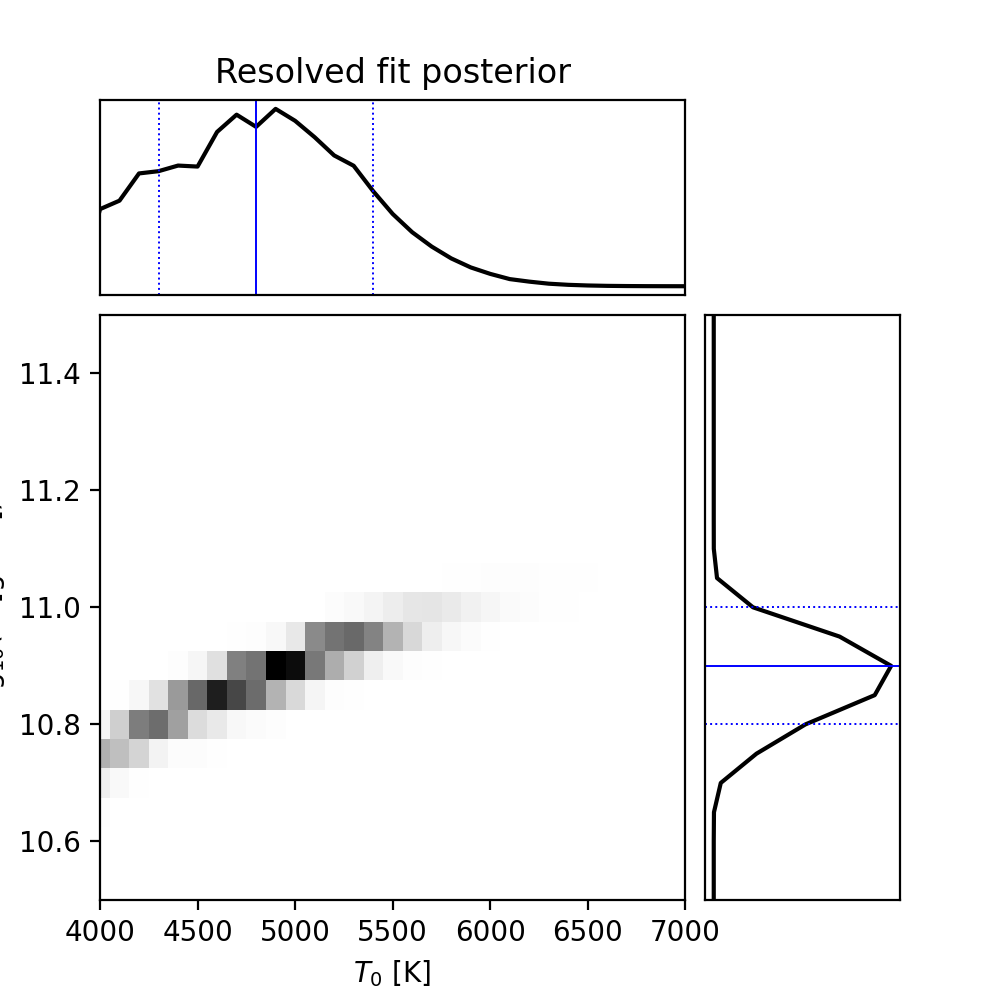

<IPython.core.display.Javascript object>


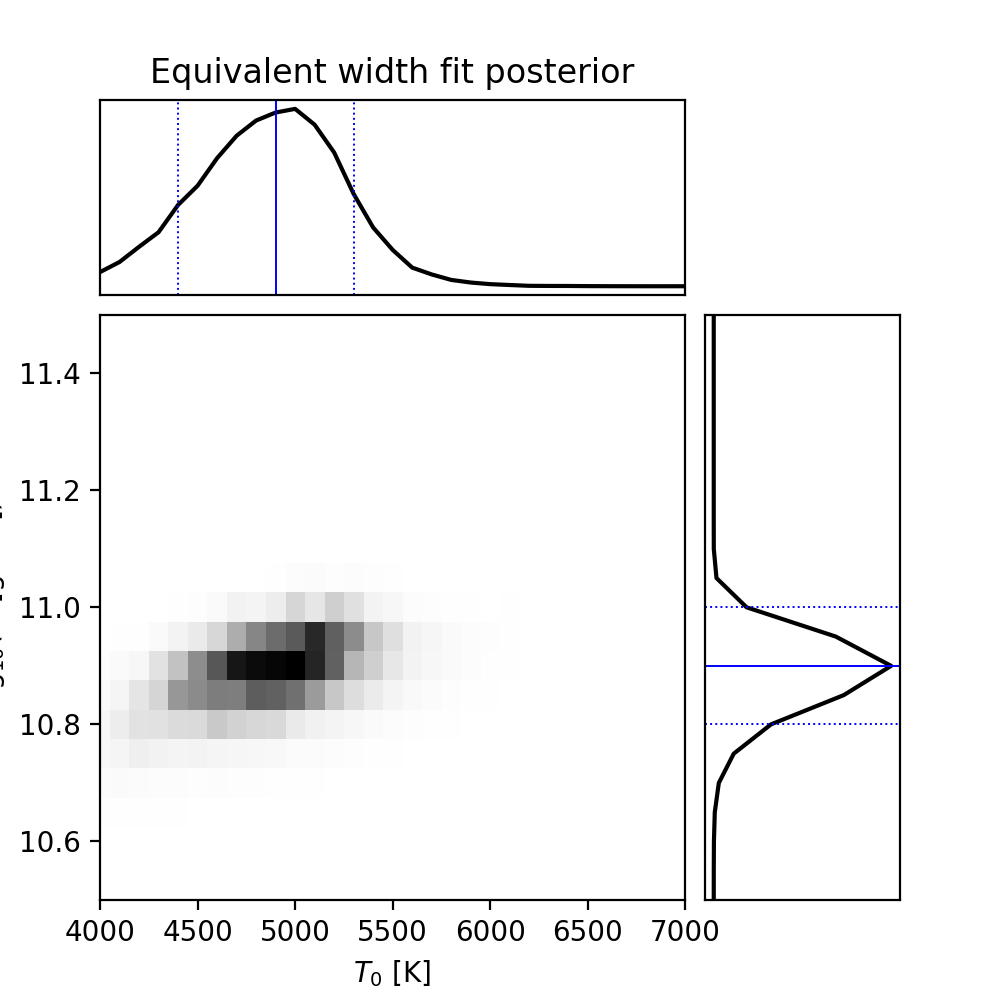

In [14]:
plot_posterior(posterior_resolved, bounds_T0=(4000,7000), bounds_Mdot=(10.5,11.5), title='Resolved fit posterior')

plot_posterior(posterior_unresolved, bounds_T0=(4000,7000), bounds_Mdot=(10.5,11.5), title='Equivalent width fit posterior')

### Results

Finally, we plot the results in a way that reproduces Fig. 6 of Linssen et al. (2024).

<IPython.core.display.Javascript object>


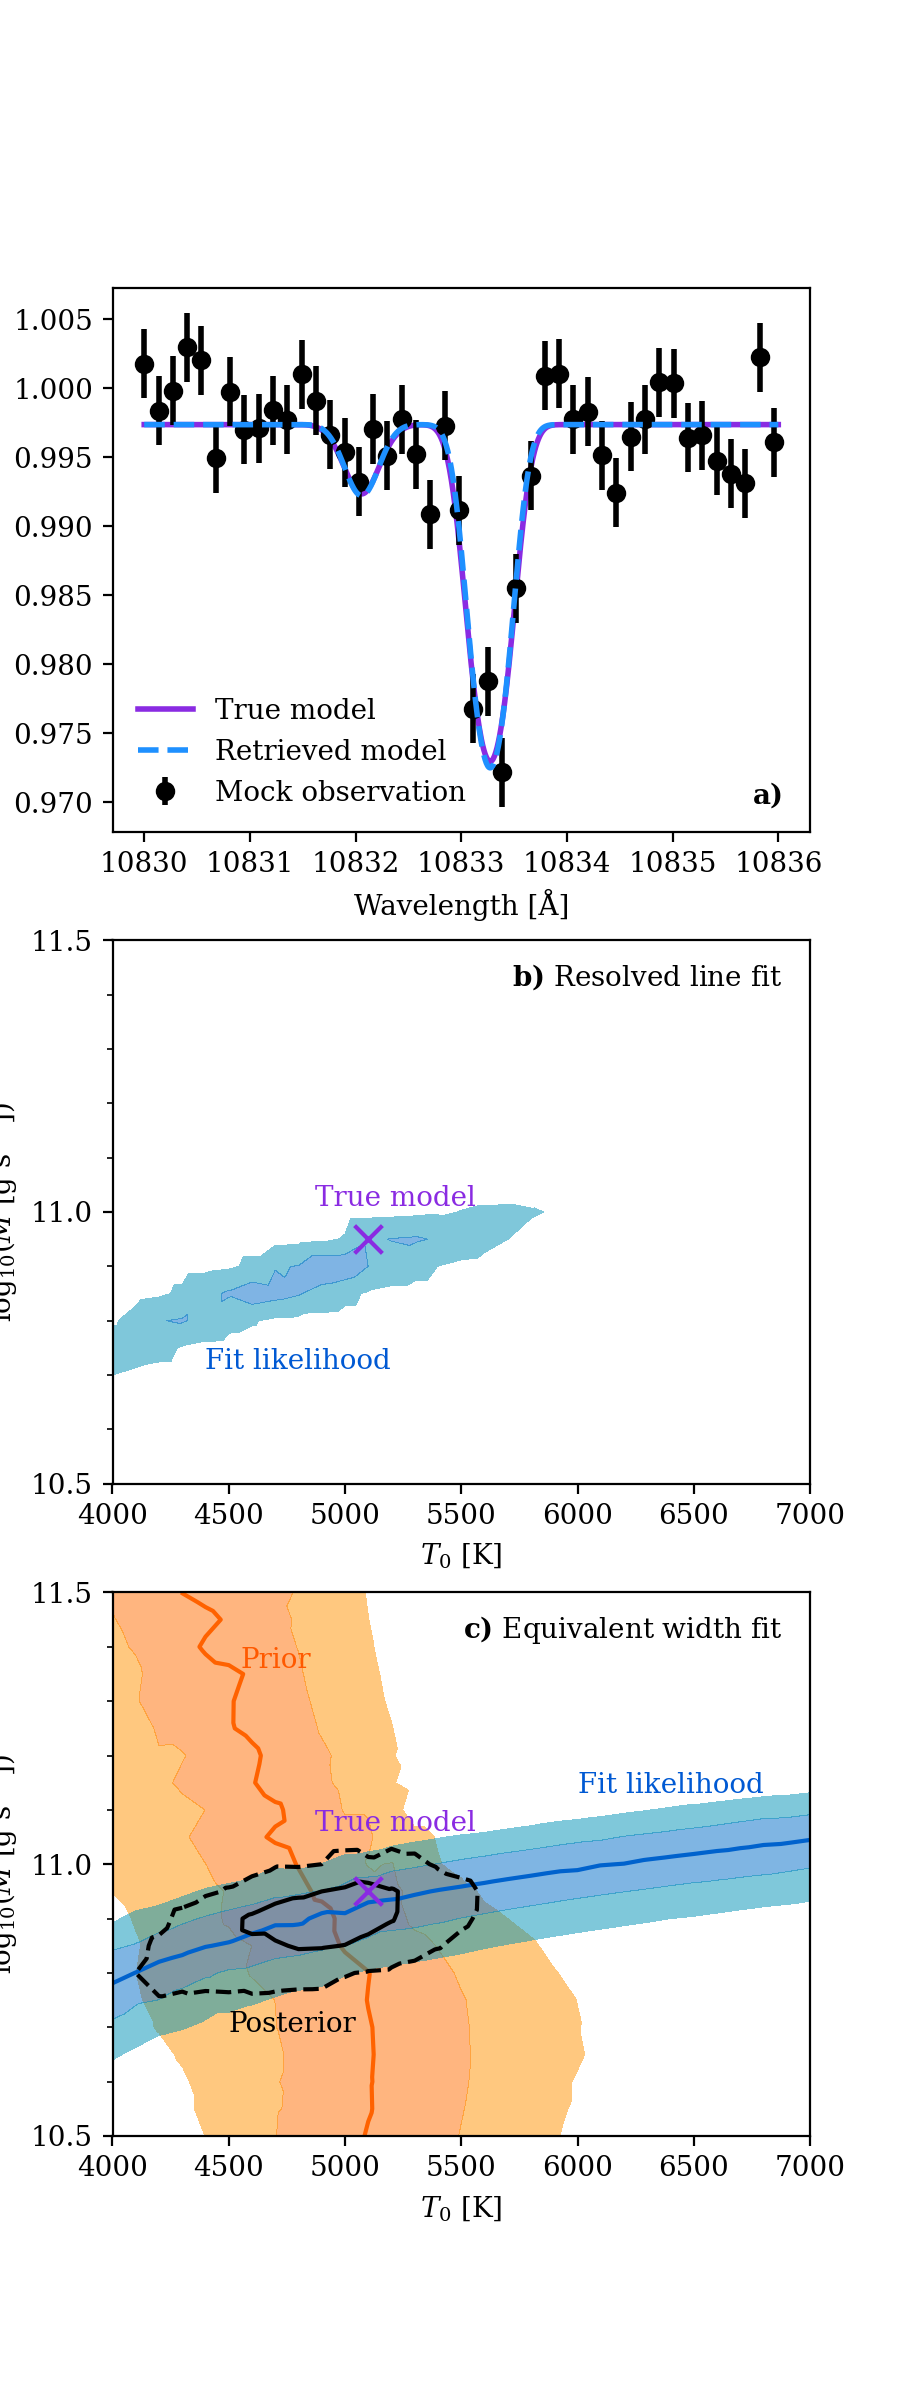

1 sigma constraints:
log10(Mdot) = 10.9 + 0.06793855530304249 - 0.05619954871618482
T0 = 5000.0 + 227.31345196987695 - 442.4995430827812


In [15]:
with plt.rc_context({"font.family": "serif", "mathtext.fontset": "dejavuserif"}): #identical to paper

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(4.5,12))

    #######

    #re-calculate the best-fit spectrum
    bestfitsim = tools.Sim(tools.projectpath+"/sims/1D/hotNeptune/z_1/parker_4800_10.900/converged")
    bestspec, _, _ = RT.FinFout(bestfitsim, highres_wavs, 'He')
        
    axes[0].plot(highres_wavs, highres_true_spec, color='blueviolet', label='True model', lw=2, zorder=-20)
    axes[0].errorbar(wavs, observed_spec, yerr=observed_errorbar, fmt='o', color='black', label='Mock observation', lw=2, zorder=-10)
    axes[0].plot(highres_wavs, bestspec, color='dodgerblue', label='Retrieved model', linestyle='dashed', lw=2, zorder=-5)
    axes[0].text(0.96,0.04, r'$\bf{a)}$', ha='right', va='bottom', transform=axes[0].transAxes)
    axes[0].set_xlabel("Wavelength [Å]")
    axes[0].set_ylabel(r"$F_{in}$/$F_{out}$")
    axes[0].legend(loc="lower left", edgecolor='none', facecolor='none', framealpha=0)
    axes[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

    #######

    plot_joint_constraint_resolved(None, None, chisqs, None, bounds_T0=(4000,7000), 
                                   bounds_Mdot = (10.5, 11.5), fig=fig, ax=axes[1])
    axes[1].scatter(5100, 10.95, marker='x', color='blueviolet', s=100, zorder=100) #the true model
    axes[1].text(4870, 11, 'True model', color='blueviolet', ha='left', va='bottom')
    axes[1].text(4400,10.75, 'Fit likelihood', ha='left', va='top', color=plt.get_cmap('winter_r')(0.65))
    axes[1].text(0.96,0.96, r'$\bf{b)}$ Resolved line fit', ha='right', va='top', transform=axes[1].transAxes)
    axes[1].set_yticks(np.arange(10.6,11.41, 0.1), minor=True)
    
    #######
    
    plot_joint_constraint_unresolved(dT, sigmaT, nsig_fit, posterior_unresolved, bounds_T0=(4000,7000), 
                                   bounds_Mdot = (10.5, 11.5), fig=fig, ax=axes[2], post_uptosigma=2)
    axes[2].scatter(5100, 10.95, marker='x', color='blueviolet', s=100, zorder=100) #the true model
    axes[2].text(4870, 11.05, 'True model', color='blueviolet', ha='left', va='bottom')
    axes[2].text(4550,11.4, 'Prior', ha='left', va='top', color=plt.get_cmap('autumn')(0.35))
    axes[2].text(6000,11.17, 'Fit likelihood', ha='left', va='top', color=plt.get_cmap('winter_r')(0.65))
    axes[2].text(4500,10.73, r'Posterior', ha='left', va='top', color='black')
    axes[2].text(0.96,0.96, r'$\bf{c)}$ Equivalent width fit', ha='right', va='top', transform=axes[2].transAxes)
    axes[2].set_yticks(np.arange(10.6,11.41, 0.1), minor=True)
    
    #######
    
    plt.show()

In the above plots, the orange contours represent the prior: the self-consistency of the Parker wind models. It presents the same quantity ($dT = T_{He} - T_0$) as the red-white-blue plots from Step 4. The orange line are models with $dT=0$, and the dark and light shaded areas represent the 1 and 2 $\sigma_T$ contours (Eq. 5 of Linssen et al. 2022).  The blue contours represent the likelihood: the fits of the model to the observed helium line. In panel b), the blue contours presents the likelihood converted into a posterior assuming a flat prior, showing the 1 and 2 $\sigma$ regions. In panel c), the blue contours presents the same quantity ($\Delta \sigma$) as the plots from Step 3. The blue line are the models for which the EW is equal to that of the data, and the dark and light shaded areas represent 1 and 2 errorbars offset in EW. The black line represents the 1 $\sigma$ contour of the posterior and can be understood as the final constraints on the temperature and mass-loss rate of the planet from the EW fit analysis.

The plotting function also prints the constraints. You may note that there are small differences between these constraints and those printed between the `calc_posterior()` function. This is because the `calc_posterior()` function quotes the median and 1 $\sigma$ bounds of the marginalized $T_0$ and $\dot{M}$ posteriors, at the numerical precision of the parameter grid. The `plot_joint_constraint_unresolved()` function instead quotes the maximum and  $\sigma$ bounds of the 2D posterior surface, at the (interpolated and hence overestimated) numerical precision of the matplotlib contour plot. 

# -------------------

# Retrieval of the observed helium spectrum of TOI-2134 b

Having seen how a typical analysis is performed, we now move on to interpreting the helium spectrum of a real planet: TOI-2134 b. We perform the analysis for two different atmospheric compositions. The steps in principle are the same as before, so we do not repeat much of the explanations. As we are working with spectrally resolved data, we use a flat prior here. However, we also calculate the model self-consistency like we did before, simply to demonstrate that there is interesting phyisics going on here, since the self-consistent temperature is very different from that indicated by the data fit. So in this case we do not convert that self-consistency measure into a prior.

### Step 1: Create a grid of Parker wind profiles with p-winds (skip if you use our pre-run models)

Here, when calculating the pure hydrogen/helium models, instead of passing the `-fH 0.91` flag which would result in using `p-winds` standalone, we use the `-z 0` flag, so that _Cloudy_ is still involved to calculate a slightly more accurate mean particle mass than `p-winds` would calculate. The composition is the same, however.

> **The full command to create a grid of 91%hydrogen/9%helium Parker wind models is**: <br><br>
> `python construct_parker.py -plname TOI2134b -pdir z_0 -T 2000 8000 100 -Mdot 8.5 10 0.02 -z 0`

> **The full command to create a grid of 100x solar metallicity Parker wind models is**: <br><br>
> `python construct_parker.py -plname TOI2134b -pdir z_100 -T 2000 8000 100 -Mdot 8.5 10 0.02 -z 100`

Additionally, with the `-cores` flag you can specify the number of parallel CPUs used.

### Step 2: Run the Parker wind profiles through Cloudy (skip if you use our pre-run models)

> **The full command to run our grid of hydrogen/helium Parker wind models through *Cloudy* is:**: <br><br>
> `python convergeT_parker.py -plname TOI2134b -dir z_0 -pdir z_0 -T 2000 8000 100 -Mdot 8.5 10 0.02 -z 0 -save_sp He`

> **The full command to run our grid of 100x solar metallicity Parker wind models through *Cloudy* is:**: <br><br>
> `python convergeT_parker.py -plname TOI2134b -dir z_100 -pdir z_100 -T 3000 14000 100 -Mdot 8.5 10 0.02 -z 100 -save_sp He`

Additionally, with the `-cores` flag you can specify the number of parallel CPUs used.

### Step 3: Make transit spectra of the metastable helium triplet and fit the data (to obtain _likelihood_)

We will again use a $\chi^2$-statistic, which assumes that the errorbars on the data are normally distributed, and that the individual datapoints are independent. In the mock spectrum analysis, this was true by definition, since we independently drew the datapoints from a normal distribution, however for real data it is worth thinking about carefully!

First, we plot the observed spectrum, which was downloaded from https://iopscience.iop.org/article/10.3847/2041-8213/aced51 . We then fit the data with a Gaussian to see if there is any offset from the rest-frame wavelength. Such offsets can definitely have a physical origin worth investigating, but as our model cannot reproduce offsets, here we shift the observed feature into the rest-frame wavelength before fitting it.

In [16]:
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-((x - mean) / std_dev) ** 2 / 2)

There is a 0.1791344919038238 angstrom shift of the line from rest-frame, which we now shift back.


<IPython.core.display.Javascript object>


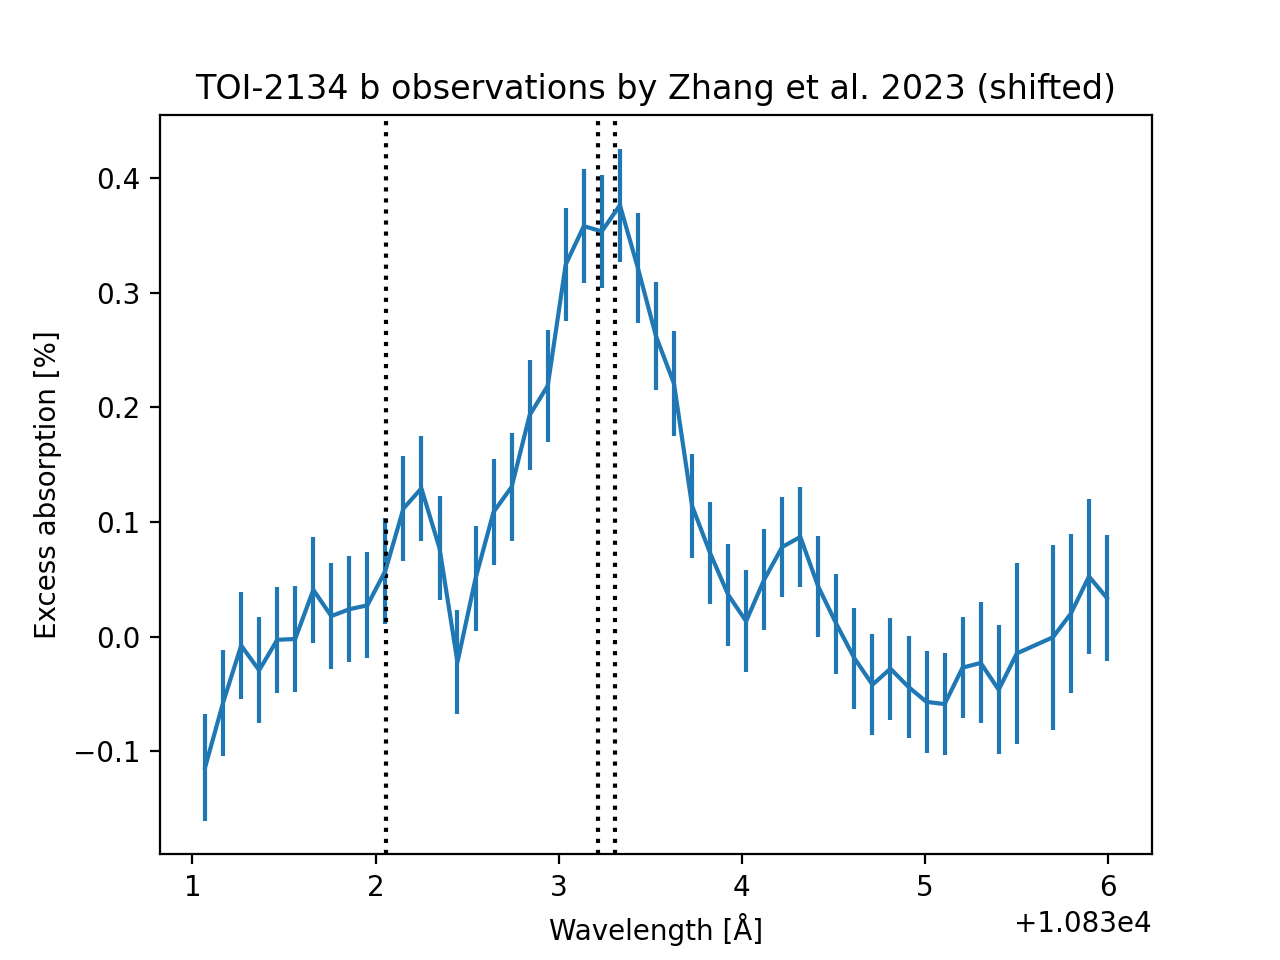

In [17]:
observed_spec_toi2134 = pd.read_table('materials/dbf2.txt', skiprows=13, 
                            names=['wav', 'ea', 'sig_ea'], delim_whitespace=True)
observed_spec_toi2134.dropna(inplace=True)

#fit a Gaussian to the peak of the data to obtain the line center
params, covariance = curve_fit(gaussian,
                               observed_spec_toi2134.wav[(observed_spec_toi2134.wav > 10832.5) & (observed_spec_toi2134.wav < 10833.8)],
                               observed_spec_toi2134.ea[(observed_spec_toi2134.wav > 10832.5) & (observed_spec_toi2134.wav < 10833.8)],
                               p0=[0.4, 10833., 0.5])
offset = params[1] - 10833.25
print("There is a", offset, "angstrom shift of the line from rest-frame, which we now shift back.")
observed_spec_toi2134.wav = observed_spec_toi2134.wav - offset


#we will not fit the whole dataset, but only the part between 10831 and 10836 angstroms
obs_wav_toi2134 = observed_spec_toi2134.wav[(observed_spec_toi2134.wav > 10831) & (observed_spec_toi2134.wav < 10836)].values
obs_ea_toi2134 = observed_spec_toi2134.ea[(observed_spec_toi2134.wav > 10831) & (observed_spec_toi2134.wav < 10836)].values
obs_sig_ea_toi2134 = observed_spec_toi2134.sig_ea[(observed_spec_toi2134.wav > 10831) & (observed_spec_toi2134.wav < 10836)].values


fig, ax = plt.subplots(1)
ax.errorbar(obs_wav_toi2134, obs_ea_toi2134, yerr=obs_sig_ea_toi2134)
ax.axvline(10832.057472, color='k', linestyle='dotted')
ax.axvline(10833.216751, color='k', linestyle='dotted')
ax.axvline(10833.306444, color='k', linestyle='dotted')
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Excess absorption [%]')
ax.set_title('TOI-2134 b observations by Zhang et al. 2023 (shifted)')
plt.show()

Uncomment the lines of the next cell and run them, if you ran your own models and want to calculate the EWs yourself, instead of using our pre-ran values.

In [18]:
#chisqs_z0 = calc_chisqs_He10830(tools.projectpath+'/sims/1D/TOI2134b/z_0/', 
#                                   obs_wav_toi2134, obs_ea_toi2134, obs_sig_ea_toi2134, 
#                                   instrument_R=32000, Mdotstep=0.02)
#chisqs_z0.to_csv('materials/TOI2134b_chisqs_fit_z0.csv') #overwrites the supplied file
#
#chisqs_z100 = calc_chisqs_He10830(tools.projectpath+'/sims/1D/TOI2134b/z_100/',
#                                     obs_wav_toi2134, obs_ea_toi2134, obs_sig_ea_toi2134,
#                                     instrument_R=32000, Mdotstep=0.02)
#chisqs_z100.to_csv('materials/TOI2134b_chisqs_fit_z100.csv') #overwrites the supplied file

In [19]:
#read the chi-squared values from file
chisqs_z0 = pd.read_csv('materials/TOI2134b_chisqs_fit_z0.csv', index_col=0, dtype=float)

chisqs_z100 = pd.read_csv('materials/TOI2134b_chisqs_fit_z100.csv', index_col=0, dtype=float)

#from chi-squared, we can calculate the likelihood
likelihood_z0 = calc_likelihood_resolved(chisqs_z0)

likelihood_z100 = calc_likelihood_resolved(chisqs_z100)

Plot the chi-squared values of the pure H/He fit:

<IPython.core.display.Javascript object>


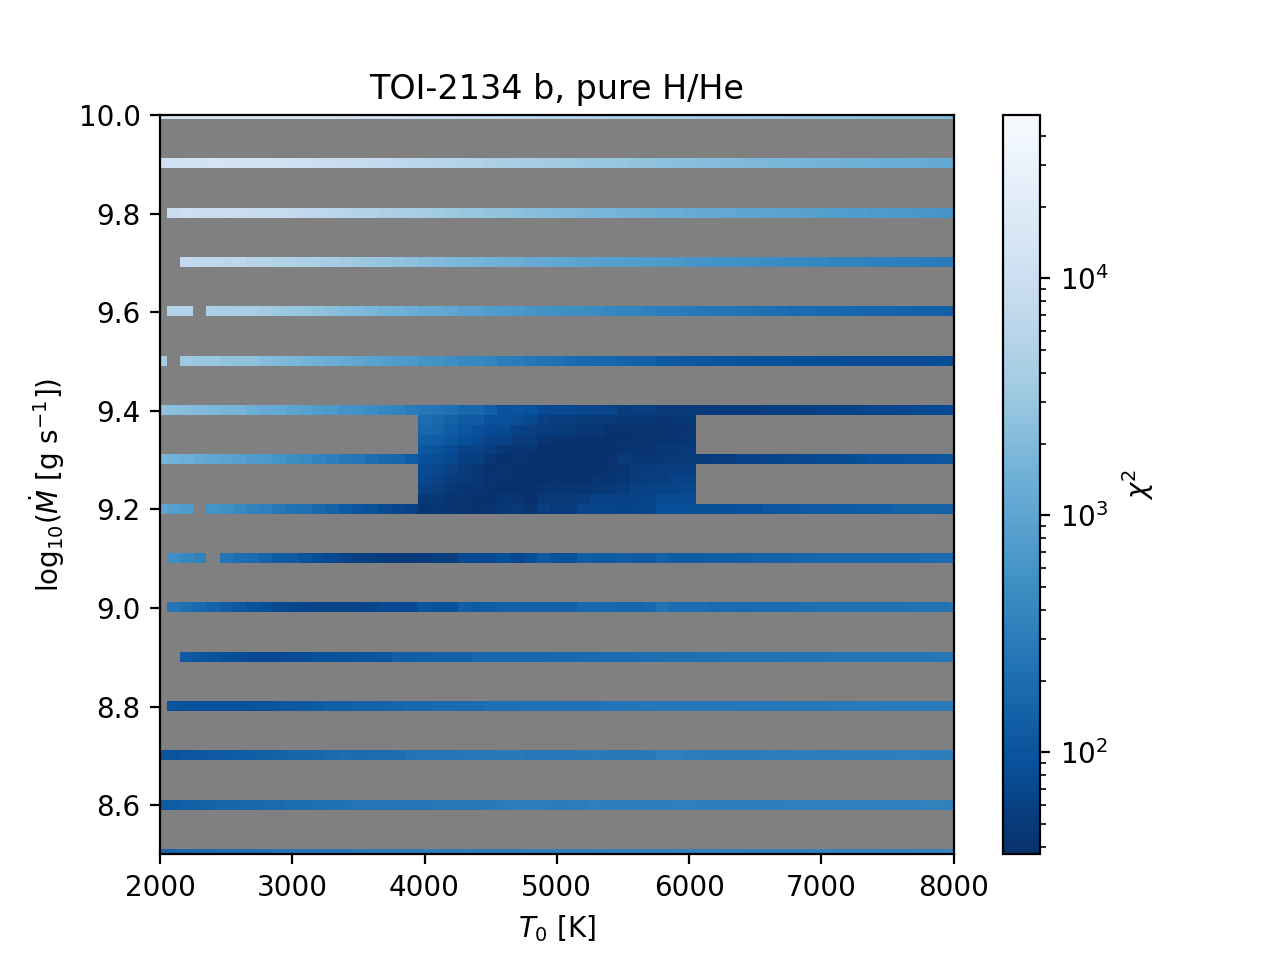

In [20]:
plot_chisq_fit(chisqs_z0, bounds_T0=(2000,8000), bounds_Mdot=(8.5,10), title="TOI-2134 b, pure H/He")

The above figure may look weird. This is because we first ran a rough grid of models, using $\dot{M}$ steps of 0.1 dex. This allowed us to see which region of parameter space fitted best. We then ran a finer grid around this region, using steps of 0.02 dex, resulting in the "striped" pattern. 

However, notice that on top of the striped pattern, there are some "holes" in the figure. These are failed models. The problem can be in _p-winds_, which sometimes fails to find a solution for specific combinations of $T_0$ and $\dot{M}$. If this is the case, the isothermal Parker wind profile will not be present in the _\$SUNBATHER_PROJECT_PATH/parker_profiles/TOI2134b/z_0/_ folder. The problem can also be a failed _Cloudy_ simulation, which can happen for example at high densities. If this is the case, you can go to the _\$CLOUDY_PATH/project/sims/1D/TOI2134b/z_0/parker_T0_Mdot/_ folder to find out why _Cloudy_ failed. Finally, in some cases the `convergeT_parker.py` module may fail to find a solution for the nonisothermal temperature structure. If this is the case, in the _\$SUNBATHER_PROJECT_PATH/sims/1D/TOI2134b/z_0/parker_T0_Mdot/_ folder, you would find "iteration" files but no "converged" files. The algorithm may converge if you try the model again using a different starting criterion with the `-startT` flag, or if you let it run for longer by specifying a higher maximum number of iterations with the `-maxit` flag. In the case of this notebook, the missing models are due to failed convergence of the temperature structure. We are continuing to improve the *sunbather* convergence algorithm, aiming to be able to converge any model in the future.

### Step 4: Constraining the parameter space by assessing temperature self-consistency

Although we will nog actually use this as a prior, we still calculate the model self-consistency for plotting and showing that it is different from the temperature indicated by the line width.

Uncomment the lines of the next cell and run them, if you ran your own models and want to calculate the model self-consistency yourself, instead of using our pre-ran values.

In [21]:
#dT_z0, sigmaT_z0 = calc_dT_helium(tools.projectpath+'/sims/1D/TOI2134b/z_0', Mdotstep=0.02)
#dT_z0.to_csv('materials/TOI2134b_dT_z0.csv', float_format='%.3e') #overwrites the supplied files
#sigmaT_z0.to_csv('materials/TOI2134b_sigmaT_z0.csv', float_format='%.3e')

#dT_z100, sigmaT_z100 = calc_dT_helium(tools.projectpath+'/sims/1D/TOI2134b/z_100', Mdotstep=0.02)
#dT_z100.to_csv('materials/TOI2134b_dT_z100.csv', float_format='%.3e') #overwrites the supplied files
#sigmaT_z100.to_csv('materials/TOI2134b_sigmaT_z100.csv', float_format='%.3e')

In [22]:
#load the dT and sigmaT values from file
dT_z0 = pd.read_csv('materials/TOI2134b_dT_z0.csv', index_col=0, dtype=float)
sigmaT_z0 = pd.read_csv('materials/TOI2134b_sigmaT_z0.csv', index_col=0, dtype=float)    

dT_z100 = pd.read_csv('materials/TOI2134b_dT_z100.csv', index_col=0, dtype=float)
sigmaT_z100 = pd.read_csv('materials/TOI2134b_sigmaT_z100.csv', index_col=0, dtype=float)

### Results

In [23]:
#we calculate the posterior with a flat prior
#we do this only so that calc_posterior() prints the constrained T0 and Mdot based on
#the likelihood alone, which we can then quote
posterior_z0 = calc_posterior(1., likelihood_z0)

posterior_z100 = calc_posterior(1., likelihood_z100)

Constraints from marginalized posteriors (not necessarily normally distributed!):
log10(Mdot) = 9.28 + 0.0600000000000005 - 0.03999999999999915
T0 = 5000.0 + 400.0 - 400.0
Constraints from marginalized posteriors (not necessarily normally distributed!):
log10(Mdot) = 9.68 + 0.040000000000000924 - 0.03999999999999915
T0 = 9700.0 + 700.0 - 700.0


Finally, we plot the results in a way that reproduces Fig. 7 of Linssen et al. (2024). The plot also shows four spectra overplotted on the observations. So, we first need to calculate the spectra of these four different models again. If you ran your own grid of TOI-2134 b models in steps 1 and 2, you will already have these models and can readily calculate their spectra. If instead, you made use of our pre-calculated grids, the four specific models that we are plotting must be copied to the right folders in *\$SUNBATHER_PROJECT_PATH*. If you did not do this yet in the "hotNeptune" section above: We have supplied all necessary files in the */sunbather/examples/materials/* folder, you just need to copy it to the correct folder structure within your project path. That is; the */sunbather/examples/materials/parker_profiles* folder must be copied/merged with your *\$SUNBATHER_PROJECT_PATH/parker_profiles* folder, and the */sunbather/examples/materials/sims* folder must be copied/merged with your *\$SUNBATHER_PROJECT_PATH/sims* folder (if you run your own models, sunbather automatically creates these folder structures).

In [24]:
sim_z0_5000 = tools.Sim(tools.projectpath+'/sims/1D/TOI2134b/z_0/parker_5000_9.280/converged') #best-fit
sim_z0_2600 = tools.Sim(tools.projectpath+'/sims/1D/TOI2134b/z_0/parker_2600_8.800/converged') #self-consistent T
sim_z100_9700 = tools.Sim(tools.projectpath+'/sims/1D/TOI2134b/z_100/parker_9700_9.680/converged') #best-fit
sim_z100_4000 = tools.Sim(tools.projectpath+'/sims/1D/TOI2134b/z_100/parker_4000_9.100/converged') #self-consistent T

#calculate spectra
wavsHe = np.linspace(10831, 10836, 200)
spec_z0_5000, _, _ = RT.FinFout(sim_z0_5000, wavsHe, 'He')
spec_z0_2600, _, _ = RT.FinFout(sim_z0_2600, wavsHe, 'He')
spec_z100_9700, _, _ = RT.FinFout(sim_z100_9700, wavsHe, 'He')
spec_z100_4000, _, _ = RT.FinFout(sim_z100_4000, wavsHe, 'He')

#convert Fin/Fout to excess absorption in %
ea_z0_5000 = (np.max(spec_z0_5000) - spec_z0_5000) * 100
ea_z0_2600 = (np.max(spec_z0_2600) - spec_z0_2600) * 100
ea_z100_9700 = (np.max(spec_z100_9700) - spec_z100_9700) * 100
ea_z100_4000 = (np.max(spec_z100_4000) - spec_z100_4000) * 100

#convolve to instrument resolution
ea_z0_5000 = RT.convolve_spectrum_R(wavsHe, ea_z0_5000, 32000)
ea_z0_2600 = RT.convolve_spectrum_R(wavsHe, ea_z0_2600, 32000)
ea_z100_9700 = RT.convolve_spectrum_R(wavsHe, ea_z100_9700, 32000)
ea_z100_4000 = RT.convolve_spectrum_R(wavsHe, ea_z100_4000, 32000)

<IPython.core.display.Javascript object>


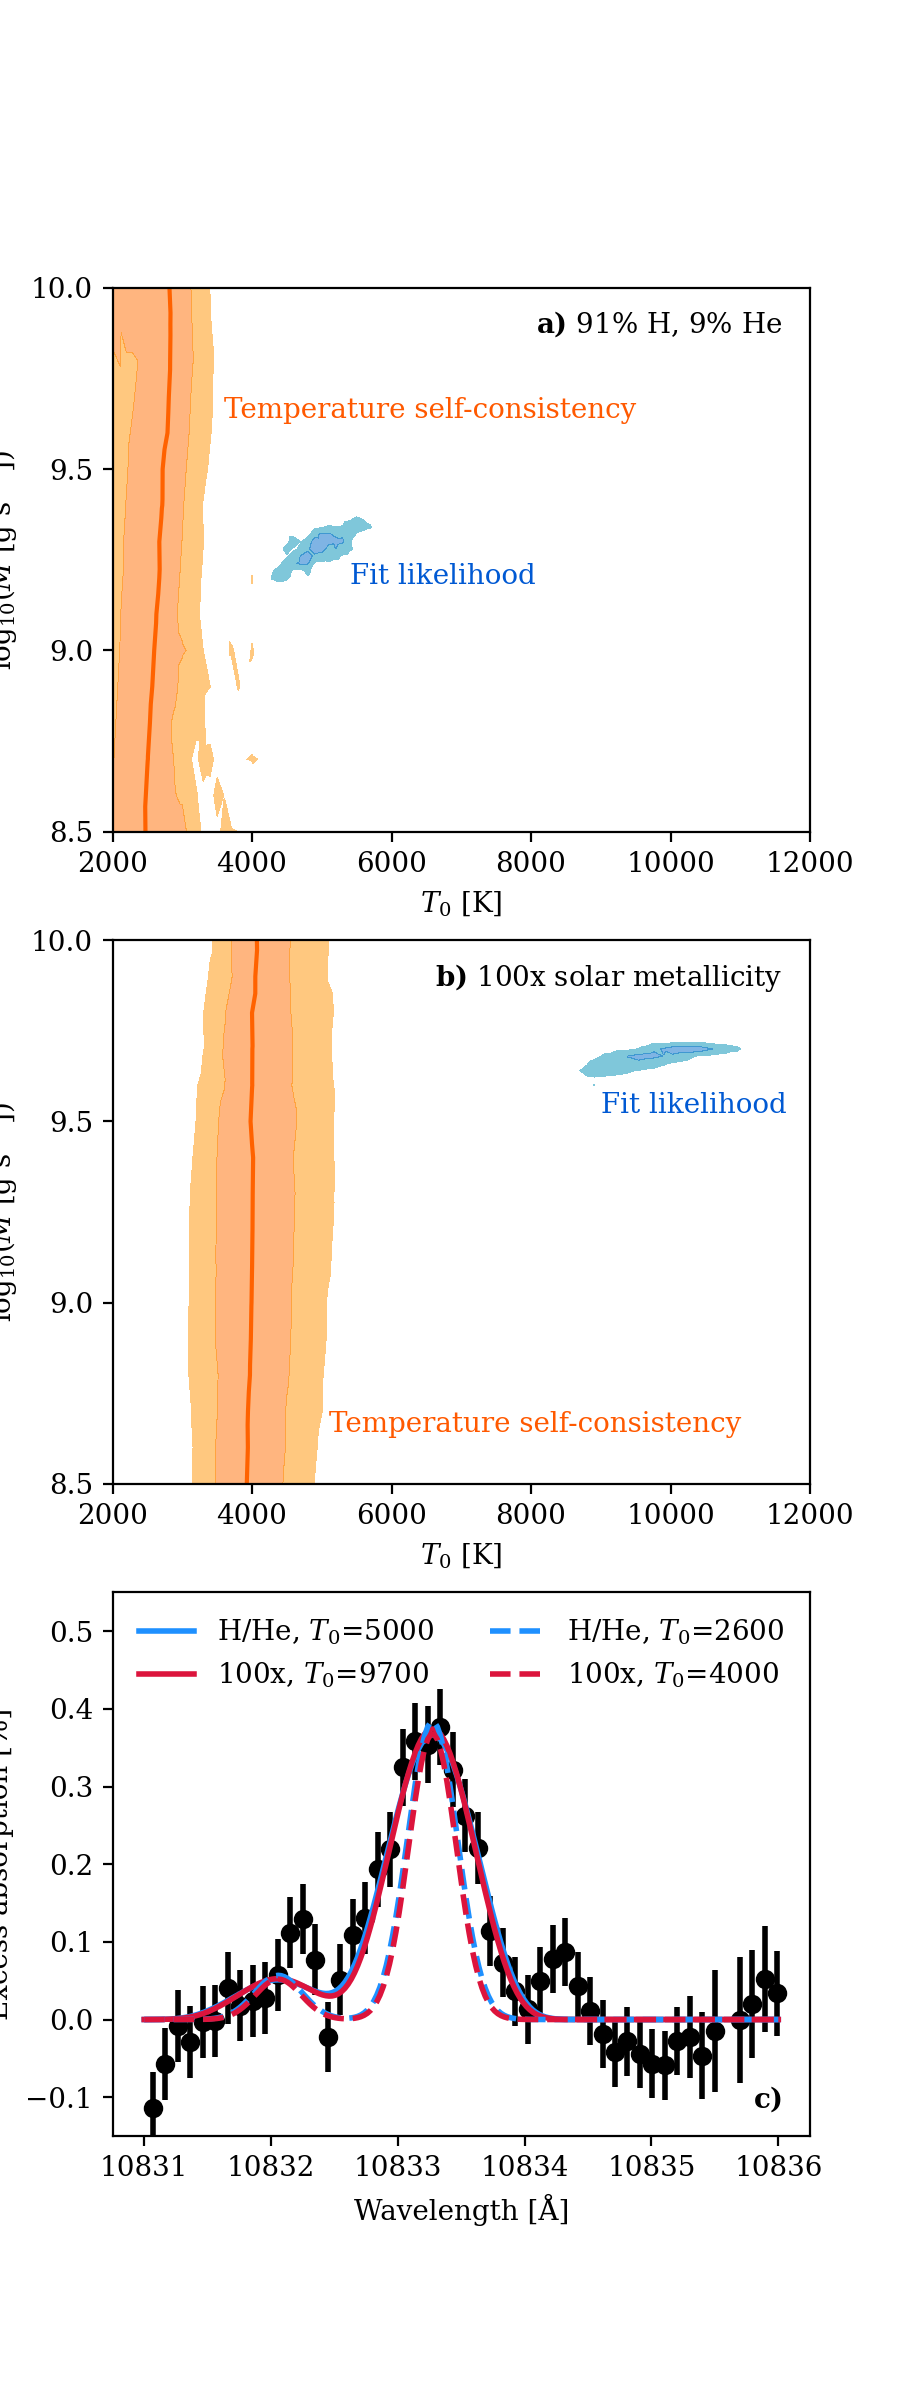

In [25]:
with plt.rc_context({"font.family": "serif", "mathtext.fontset": "dejavuserif"}):
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(4.5,12))

    ##########
    
    plot_joint_constraint_resolved(dT_z0, sigmaT_z0, chisqs_z0, None, 
                                   bounds_T0=(2000,12000), bounds_Mdot = (8.5, 10), fig=fig, ax=axes[0])
    
    axes[0].text(0.96,0.96, r'$\bf{a)}$'+' 91% H, 9% He', ha='right', va='top', transform=axes[0].transAxes)
    axes[0].text(3600,9.7, 'Temperature self-consistency', ha='left', va='top', color=plt.get_cmap('autumn')(0.35))
    axes[0].text(5400,9.24, 'Fit likelihood', ha='left', va='top', color=plt.get_cmap('winter_r')(0.65))

    ##########
    
    plot_joint_constraint_resolved(dT_z100, sigmaT_z100, chisqs_z100, None, 
                               bounds_T0=(2000,12000), bounds_Mdot = (8.5, 10), fig=fig, ax=axes[1])

    axes[1].text(0.96,0.96, r'$\bf{b)}$'+' 100x solar metallicity', ha='right', va='top', transform=axes[1].transAxes)
    axes[1].text(5100,8.7, 'Temperature self-consistency', ha='left', va='top', color=plt.get_cmap('autumn')(0.35))
    axes[1].text(9000,9.58, 'Fit likelihood', ha='left', va='top', color=plt.get_cmap('winter_r')(0.65))

    ##########

    axes[2].errorbar(obs_wav_toi2134, obs_ea_toi2134, yerr=obs_sig_ea_toi2134, 
                     fmt='o', color='black', zorder=-100, lw=2)
    axes[2].plot(wavsHe, ea_z0_5000, label=r'H/He, $T_0$=5000', color='dodgerblue', lw=2)
    axes[2].plot(wavsHe, ea_z100_9700, label=r'100x, $T_0$=9700', color='crimson', lw=2)
    axes[2].plot(wavsHe, ea_z0_2600, label=r'H/He, $T_0$=2600', color='dodgerblue', linestyle='dashed', lw=2)
    axes[2].plot(wavsHe, ea_z100_4000, label=r'100x, $T_0$=4000', color='crimson', linestyle='dashed', lw=2)
    axes[2].text(0.96,0.04, r'$\bf{c)}$', ha='right', va='bottom', transform=axes[2].transAxes)
    axes[2].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    axes[2].set_xlabel('Wavelength [Å]')
    axes[2].set_ylabel('Excess absorption [%]')
    axes[2].legend(loc="upper right", edgecolor='none', facecolor='none', framealpha=0, ncols=2)
    axes[2].set_ylim(-0.15, 0.55)

    ##########
    
    plt.show()

We see that the temperature obtained from the line fit is very different from the self-consistency constraint. In Linssen et al. (2024), we discuss the temperature discrepancy between the line fit and the self-consistency in more detail.